# Trading Tesla with Machine Learning and Sentiment Analysis

In this project, we will aim to use a Machine Learning model to predict the daily prices of the Tesla stock. Along with several technical indicators derived from the OHLCV data, we will feed into the model also the sentiment scores of relevant Twitter posts, thus leveraging **Sentiment Analysis**, a Natural Language Processing technique. All these data will be used to train the model, which in turn will predict the trading signals. Finally, we will backtest the trading strategy and display some performance metrics.

Sentiment analysis and generally the positive or negative sentiment on news about a stock has been studied in depth in the recent years, finding a strong correlation between the sentiment scores of such data and the stock price movement <sup><a href='#References'>[1]</a></sup>.

The labels we need to predict are the buy and sell signals, which we will assign based on simple price conditions in order to train the model. Since these are discrete data, the problem we are trying to solve is a supervised classification.

The Machine Learning model we will use is the **Random Forest Classifier**. Random Forests are supervised algorithms consisting of multiple decision trees performing well with non-linear data and with low risk of overfitting. They are also strong against outliers, although they suffer from low interpretability compared to single decision trees <sup><a href='#References'>[2]</a></sup>.

The reliability of the Random Forest in predicting stock prices is widely confirmed by many studies, suggesting the robustness of this model when compared to other machine learning algorithms. The paper "Predicting Stock Market Price Direction with Uncertainty Using Quantile Regression Forest" <sup><a href='#References'>[3]</a></sup> raises an observation regarding the uncertainty of the predictions of the Random Forest model, stating that it's a scarcely studied subject. This is surely an aspect worth to investigate for researchers, given the financial risk involved with applications such as algorithmic trading.

In this project we will also leverage various techniques, data structures and paradigms, such as **concurrency** and **parallel processing**, **functional and object-oriented programming**, **idempotence**, **Direct Acyclic Graph** and **data pipeline**.

The intention behind this project is to implement the end-to-end workflow of the backtesting of an **Algorithmic Trading** strategy in a program with a sleek interface, and with a level of automation such that the user is able to tailor the details of the strategy and the output of the program by entering a minimal amount of data, partly even in an **interactive** way. This should make the program **reusable**, meaning that it's easy to carry out the backtesting of the trading strategy on a different asset. Furthermore, the **modularity** of the software design should facilitate changes to adapt the program to different requirements (i.e. different data or ML models).

**Please be aware that the content and results of this project do not represent financial advice. You should conduct your own research before trading or investing in the markets. Your capital is at risk.**

In [129]:
import pandas as pd
import numpy as np
from collections import deque
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import snscrape.modules.twitter as sntwitter
import csv
from datetime import datetime, date, timedelta
import glob
import os
import re
import copy
import talib as ta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import multiprocessing as mp
import threading
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn import metrics
from joblib import dump, load
from pprint import pprint
import json
import warnings
warnings.filterwarnings("ignore")

## The data download and manipulation pipeline

We will implement a Directed Acyclic Graph (DAG) wrapped into a pipeline class to manage the Twitter data and stock prices download and manipulation. The pipeline will manage the data folders creation, the data download operations as well as the validation of the input parameters required by the user so that the aggregated data for the machine learning model will update automatically based on the initial parameters passed. This will make the project reusable and will leave a friendly interface to the user, who will be required to enter the parameters once at the beginning before running the pipeline.

A Directed Acyclic Graph is a set of nodes with a direction and where it's not possible to find a cyclic path <sup><a href='#References'>[4]</a></sup>. A DAG goes beyond a simple data structure, it's versatile and in fact is used in a wide range of applications, from project management to distributed ledgers' technology such as blockchain. 

I built the DAG used in this project whilst studying and completing the Data Engineer course taken on the online learning platform Dataquest <sup><a href='#References'>[5]</a></sup> some time ago.

Let's define the directed acyclic graph class:

In [130]:
class DAG:
    """Directed Acyclic Graph.
    
    Attributes:
        graph: dict type, nodes container
    
    Methods:
        in_degrees(): number of nodes dependencies
        sort(): order nodes in increasing dependencies
        add(node, to=None): add node and pointed (if passed) to graph 
    """
    
    def __init__(self):
        self.graph = {}

    def in_degrees(self):
        """Build and return dict of pairs node : number of pointers to node.
        """
        
        in_degrees = {}
        for node in self.graph:
            if node not in in_degrees:
                in_degrees[node] = 0
            for pointed in self.graph[node]:
                if pointed not in in_degrees:
                    in_degrees[pointed] = 0
                in_degrees[pointed] += 1
        return in_degrees

    def sort(self):
        """Return sorted list of nodes.
        Sorting from roots to most pointed nodes.
        """
        
        in_degrees = self.in_degrees()
        to_visit = deque()
        for node in self.graph:
            if in_degrees[node] == 0:
                to_visit.append(node)

        searched = []
        while to_visit:
            node = to_visit.popleft()
            for pointer in self.graph[node]:
                in_degrees[pointer] -= 1
                if in_degrees[pointer] == 0:
                    to_visit.append(pointer)
            searched.append(node)
        return searched

    def add(self, node, to=None):
        """ Add node and pointed node.
        If pointed node is not in graph, add it.
            
        Arguments:
            node: function
            to: function, takes node output as input
        """
        if node not in self.graph:
            self.graph[node] = []
        if to:
            if to not in self.graph:
                self.graph[to] = []
            self.graph[node].append(to)
        if len(self.sort()) != len(self.graph):
            raise Exception

And the pipeline class:

In [131]:
class Pipeline:
    """Wrapper of DAG data structure. Interface to add
    and run tasks.
    
    Methods:
        task(): wrapper for DAG's add method, pass task to DAG
        run(): run pipeline tasks
    """
    
    def __init__(self):
        self.tasks = DAG()

    def task(self, depends_on=None):
        """Add task and its dependency (if passed)
        
        Arguments:
            depends_on: function whose output is input for given task
        """
        
        def inner(f):
            self.tasks.add(f)
            if depends_on:
                self.tasks.add(depends_on, f)
            return f
        return inner

    def run(self):
        """Run tasks and return dict of pairs task : output
        """
        
        scheduled = self.tasks.sort()
        completed = {}

        for task in scheduled:
            for node, values in self.tasks.graph.items():
                if task in values:
                    completed[task] = task(completed[node])
            if task not in completed:
                completed[task] = task()
        return completed

### Instantiate a Pipeline instance

We can now initialise an instance of the pipeline, so that we can push the functions which will manage the data download and manipulation inside the D.A.G. pipeline object.

In [132]:
 TSLA_data_pipeline = Pipeline()

### Using multithreading and multiprocess computing

As we will be dealing with multiple data files to download and process, and long computations such as the sentiment scores calculations on the Twitter posts, we would benefit from using multiprocess and multithread computation. During the project development, I have identified few tasks that represented a bottleneck for the execution's speed due to the process running serially. Thus, we will implement concurrency and parallelism as follows:
<br>
<br>
* tweets and prices data download: multithread
* tweets aggregation: multiprocess
* tweets sentiment score: multiprocess

<br>
<br>
The above solution is consistent with the characteristics of these two techniques: the download is an i/o bound process and so it benefits from multiple threads, whereas the tweets aggregation and the computation of the sentiment scores on a large amount of data are CPU bound computations, therefore it can benefit from exploiting all the cores available.
Let's define then two classes for handling multiprocess and multithread tasks:

In [133]:
class Multiprocess_Executor():
    """
    Wrapper class for multiprocess executor.
        
    Attributes:
        path = directory, path to files to process
        make_tasks_pool = function, must take path as input and return iterable of tasks
        tasks_pool = iterable, pool of tasks to be executed by worker
        worker: function, must take single task as input
        handle_outputs_pool = function, must take iterable of outputs as input
        n_cores = int, numbers of cores detected
        
    Methods:
        make_tasks_pool: wrapper for make_tasks_pool function
        handle_outputs_pool: wrapper for handle_outputs_pool function
        execute: public, class caller to run all from reading in path to handling outputs
    """
    
    def __init__(self, to_do, make_tasks_pool, worker, handle_outputs_pool):
        self.to_do = to_do
        self.make_tasks_pool = make_tasks_pool
        self.tasks_pool = self.make_tasks_pool(to_do)
        self.worker = worker
        self.handle_outputs_pool = handle_outputs_pool
        self.n_cores = mp.cpu_count()
    
    def make_tasks_pool(self):
        return self.make_tasks_pool(self.to_do)
    
    def handle_outputs_pool(self, outputs_pool):
        return self.handle_outputs_pool(outputs_pool)
        
    def execute(self):
        processes = ProcessPoolExecutor(max_workers=self.n_cores, mp_context=mp.get_context('fork'))
        outputs_pool = list(processes.map(self.worker, self.tasks_pool))
        return self.handle_outputs_pool(outputs_pool)

In [134]:
class Multithread_Executor():
    """
    Wrapper class for multithread executor.
        
    Attributes:
        path = directory, path to files to process
        make_tasks_pool = function, must take path as input and return iterable of tasks
        tasks_pool = iterable, pool of tasks to be executed by worker
        worker: function, must take single task as input
        handle_outputs_pool = function, must take iterable of outputs as input
        n_threads = int, initialised as number of tasks in the pool
        
    Methods:
        make_tasks_pool: wrapper for make_tasks_pool function
        handle_outputs_pool: wrapper for handle_outputs_pool function
        execute: public, class caller to run all from reading in path to handling outputs
    """
    
    def __init__(self, to_do, make_tasks_pool, worker, handle_outputs_pool):
        self.to_do = to_do
        self.make_tasks_pool = make_tasks_pool
        self.tasks_pool = self.make_tasks_pool(to_do)
        self.worker = worker
        self.handle_outputs_pool = handle_outputs_pool
        self.n_threads = min(len(self.tasks_pool), 4)
    
    def make_tasks_pool(self):
        return self.make_tasks_pool(self.path)
    
    def handle_outputs_pool(self, outputs_pool):
        return self.handle_outputs_pool(outputs_pool)
        
    def execute(self):
        threads = ThreadPoolExecutor(max_workers=self.n_threads)
        outputs_pool = list(threads.map(self.worker, self.tasks_pool))
        return self.handle_outputs_pool(outputs_pool)

The Multiprocess_Executor and Multithread_Executor classes represent a general interface for the parallel computing workflow in Python as implemented into the Executor class from concurrent.futures.

We can now proceed to define the specific functions passed into the class, as needed for each task we'll need to carry out.

## The data download and manipulation functions

We can now proceed to write the functions which will handle the data (historical prices and Twitter posts) download and manipulation. These functions will be pushed into the Pipeline class object. This serves as wrapper and organizer (through the DAG structure) for the functions, which will be executed in order and each function output will be fed as input to the next function in the pipeline.

### Managing the data folder

The first task we want to perform is managing the root directory where the downloaded files will be saved. We will have a "data" folder as root and the first subdirectory will be named as the ticker of the stock on which we will be running the analysis and ML model, in this case TESLA, which is listed as "TSLA".

&nbsp;

The "data" directory will have the following structure:

data
  └── prices
  └── tweets_raw
  └── tweets_unstacked
  └── tweets_merged
  └── tweets_sentiment_scores
  └── prices_TI_sentiment_scores
  └── strategy_performance
  └── model_training_parameters
                               └── best_params
                               └── param_grids

Let's write a function that will initiate the pipeline by checking if the "data" folder has been already created, and if not, it creates it. The function will simply return the "data" folder path so that the next function in the pipeline can take the job from there.

In [135]:
@TSLA_data_pipeline.task()
def manage_data_directory():
    """
    Check if the root directory for storing the project data exists.
    Create it if it doesn't exist.
    Return directory name.
    """
    
    root = 'data/'
    if os.path.isdir(root):
        print('The "data" directory already exists. Now working on prices and tweets download:')
    else:
        os.makedirs(root, exist_ok=True)
        print('"data" directory created. Now working on prices and tweets download:\n')
    return root

### The input parameters

The scope of the pipeline is to abstract the user from the download and manipulation of data, leaving to her/him only the task to set the download parameters such as the dates of the period on which to run the analysis, the Twitter accounts where to retrieve the posts and some preferences as to how to perform the tweets search.

Let's define a data structure where the user will input these parameters. We will use a dictionary, as it allows us to have a nested mapping of the key parameters needed for the data download.

The dictionary's structure is represented below:

```python
download_params = {'ticker' : 'TSLA',
                   'since' : '2010-06-29', 
                   'until' : '2021-06-02',
                   'twitter_scrape_by_account' : {'elonmusk': {'search_keyword' : '',
                                                               'by_hashtag' : False},
                                                  'tesla': {'search_keyword' : '',
                                                            'by_hashtag' : False},
                                                  'WSJ' : {'search_keyword' : 'Tesla',
                                                           'by_hashtag' : False},
                                                  'Reuters' : {'search_keyword' : 'Tesla',
                                                               'by_hashtag' : False},
                                                  'business': {'search_keyword' : 'Tesla',
                                                               'by_hashtag' : False},
                                                  'CNBC': {'search_keyword' : 'Tesla',
                                                           'by_hashtag' : False},
                                                  'FinancialTimes' : {'search_keyword' : 'Tesla',
                                                                      'by_hashtag' : True}},
                   'twitter_scrape_by_most_popular' : {'all_twitter_1': {'search_keyword' : 'Tesla',
                                                                       'max_tweets_per_day' : 30,
                                                                       'by_hashtag' : True}},
                   'language' : 'en'                                      
                  }
```

The meaning and use of the keys in the dictionary is as follows:
<br>
<br>
* "ticker": the symbol of the stock
* "since": the start date for historical prices and tweets
* "until": the end date for historical prices and tweets
* "language": the code representing the language for the tweets (if in doubt, consult the Twitter API)
* "twitter_scrape_by_account": details to download tweets from a single Twitter account searching by a keyword
    * the key in each entry (i.e "elonmusk", "Reuters" in the instance above) must be the username (handle) of the Twitter account
    * "search_keyword" is the keyword to look for in the tweets
    * if the "search_keyword" value is an empty string, all the tweets posted by the account will be downloaded
    * "by_hashtag" is a boolean to define whether to use the keyword as hashtag or simple text
* "twitter_scrape_by_most_popular": details to download tweets from any Twitter accounts searching by a keyword and ranked by most retweeted
    * the key (i.e. "all_twitter_1" in the instance above) can be anything, as it's not used for file naming purposes. If multiple entries in "twitter_scrape_by_most_popular", make sure these keys are different
    * "search_keyword" is the keyword to look for in the tweets. Ideally a keyword should be passed, otherwise it will try to download any tweets posted on Twitter between the provided timeframe and this may slow down or make the download fail
    * "max_tweets_per_day": the maximum number of tweets to select for each day. They will be ranked by number of retweet after all tweets are scraped
    * "by_hashtag" is a boolean to define whether to use the keyword as hashtag or simple text

<br>
Few rules to keep in mind whilst filling up the download parameters dictionary:
<br>
<br>

* All "ticker", "since", "until", "language", "twitter_scrape_by_account", "twitter_scrape_by_most_popular" key/value pairs are required
* If there are no entries for "twitter_scrape_by_account" or "twitter_scrape_by_most_popular", just enter as value an empty list [], tuple () or string "" instead

#### Use of Idempotence

The intention behind the pipeline, as mentioned earlier, is to abstract the download and manipulation of data from the user. This means that we want to handle any variations the user wants to bring in sourcing the data (mostly tweets, but also dates of the period of the analysis and historical prices consequently).

To do so, we have to keep a log of the status for the content of data, prices and tweets, in the root folder. Thus, if the user changes any of the download parameters, the pipeline will handle that change and download only what has been added and delete what has been suppressed from the parameters. This will give complete control on the files downloaded and manipulated by just altering the download parameters dictionary.

We will achieve this by naming the files based on all the parameters, so that there is an unambiguous relation between download parameters and file names, which allows us to scan the data folder and let the pipeline execute the job needed to update all the data based on the current download parameters.

This concept is known as idempotence, the property of a function to give the same output any times it is called with the same input <sup><a href='#References'>[6]</a></sup>.

### Historical prices download

Let's write first a function to handle the historical prices download:

In [136]:
@TSLA_data_pipeline.task(depends_on=manage_data_directory)
def download_prices(root):
    """
    Scan or create prices folder in root data directory.
    Download relevant historical prices (as per download_params).
    Delete non relevant existing prices file.
    Return prices folder path for next prices' manipulation function in the pipeline.
    
    Arguments:
        root: string, project's data root directory.
    """
    
    # Build prices file name
    ticker = download_params['ticker'] + '_'
    since = download_params['since'].replace('-','') + '_'
    until = download_params['until'].replace('-','') + '_'
    prices_filename = ticker + since + until + 'prices.csv'
    
    # If prices directory does not exist
    prices_folder = root + 'prices/'
    if not os.path.exists(prices_folder):
        # create it
        os.makedirs(prices_folder)
        # download and save prices with file name
        ticker = download_params['ticker']
        since = download_params['since']
        until = download_params['until']
        until_date = datetime.strptime(until, '%Y-%m-%d').date()
        until_incl = datetime.strftime(until_date + timedelta(1), '%Y-%m-%d')
        print('"prices" folder created. Downloading historical prices for', ticker + '...')
        df = yf.download(ticker, since, until_incl)
        prices_path = prices_folder + prices_filename
        df.to_csv(prices_path)
        print(ticker, 'prices downloaded in "prices" folder and saved as', prices_filename + '.')
        
    # if prices directory exists, check if relevant prices file already exists or download and save it
    else:
        print('Scanning the "prices" folder...')
        existing_files = [file.split('/')[2] for file in glob.glob(prices_folder + '*')]
        # Check also prices with technical indicators
        prices_filename_TI = prices_filename.replace('.csv', '_TI.csv')
        to_delete_files = [file for file in existing_files if (file != prices_filename and file != prices_filename_TI)]
        if (prices_filename not in existing_files) and (prices_filename_TI not in existing_files):
            # download and save prices with file name
            ticker = download_params['ticker']
            since = download_params['since']
            until = download_params['until']
            until_date = datetime.strptime(until, '%Y-%m-%d').date()
            until_incl = datetime.strftime(until_date + timedelta(1), '%Y-%m-%d')
            df = yf.download(ticker, since, until_incl)
            prices_path = prices_folder + prices_filename
            df.to_csv(prices_path)
            print(ticker, 'prices downloaded in "prices" folder and saved as', prices_filename + '.')
        
        else:
            ticker = download_params['ticker']
            print('Relevant', ticker, 'prices file already exists as', prices_filename + '.')
        
        # if irrelevant prices files in the directory, delete them
        if to_delete_files:
            for file in to_delete_files:
                file = prices_folder + file
                os.remove(file)
            print('Irrelevant existing prices files deleted.')
        
    # Return prices directory for next prices' manipulation function in the pipeline
    return prices_folder

### The technical indicators

Next in the chain and depending on the "download_prices" function will be another function to add technical indicators to the price dataset.

In [137]:
@TSLA_data_pipeline.task(depends_on=download_prices)
def technical_indicators(prices_folder):
    """
    Add technical indicators to relevant prices file.
    Return prices folder path
    
    Arguments:
        prices_folder: str, prices data folder path  
    """
    
    # Check if prices file with technical indicators exists and if not build and save it 
    prices_path = glob.glob(prices_folder + '*')
    if prices_path:
        prices_path = prices_path[0]
        
    if '_TI' not in prices_path:
        print("\nComputing technical indicators on historical prices...")
        
        # Load prices in pandas dataframe
        df = pd.read_csv(prices_path, index_col=[0])
        
        # Prepare columns for TA-lib
        Open = df['Open'].values 
        close = df['Close'].values
        high = df['High'].values
        low = df['Low'].values
        volume = df['Volume'].astype('float64').values
        
        # TA-Lib Overlap indicators
        df['BB_Up'], df['BB_Mid'], df['BB_Low'] = ta.BBANDS(close, timeperiod=20)
        df['DEMA'] = ta.DEMA(close)
        df['EMA_30'] = ta.EMA(close)
        df['HT_Trendline'] = ta.HT_TRENDLINE(close)
        df['KAMA'] = ta.KAMA(close)
        df['MA_50'] = ta.MA(close, timeperiod=50)
        df['MA_200'] = ta.MA(close, timeperiod=200)
        df['MAMA'], df['FAMA'] = ta.MAMA(close)
        df['Midpoint_14'] = ta.MIDPOINT(close)
        df['Midprice_14'] = ta.MIDPRICE(high, low)
        df['SAR'] = ta.SAR(high, low)
        #df['SAREXT'] = ta.SAREXT(high, low)
        df['T3_5'] = ta.T3(close)
        df['TEMA_30'] = ta.TEMA(close)
        df['TRIMA_30'] = ta.TRIMA(close)
        df['WMA_30'] = ta.WMA(close)
        
        # Ta-Lib Momentum indicators
        df['ADX_14'] = ta.ADX(high, low, close)
        df['ADXR_14'] = ta.ADXR(high, low, close)
        df['APO'] = ta.APO(close)
        df['Aroon_Down_14'], df['Aroon_Up_14'] = ta.AROON(high, low)
        df['Aroonosc_14'] = ta.AROONOSC(high, low)
        df['BOP'] = ta.BOP(Open, high, low, close)
        df['CCI_14'] = ta.CCI(high, low, close)
        df['CMO_14'] = ta.CMO(close)
        df['DX_14'] = ta.DX(high, low, close)
        df['MACD_12_26'], df['MACD_signal'], df['MACDhist'] = ta.MACD(close)
        df['MFI_14'] = ta.MFI(high, low, close, volume)
        df['Minus_DI_14'] = ta.MINUS_DI(high, low, close)
        df['Minus_DM_14'] = ta.MINUS_DM(high, low)
        df['MOM_14'] = ta.MOM(close)
        df['Plus_DI_14'] = ta.PLUS_DI(high, low, close)
        df['Plus_DM_14'] = ta.PLUS_DM(high, low)
        df['PPO_12_26'] = ta.PPO(close)
        df['ROC_10'] = ta.ROC(close)
        df['ROCP_10'] = ta.ROCP(close)
        df['ROCR_10'] = ta.ROCR(close)
        df['ROCR100_10'] =ta.ROCR100(close)
        df['RSI_14'] = ta.RSI(close)
        df['Stoch_Slowk_5_3'], df['Stoch_Slowd_3'] = ta.STOCH(high, low, close)
        df['Stoch_Fastk_5'], df['Stoch_Fastd_3'] = ta.STOCHF(high, low, close)
        df['StochRSI__14_Fastk_5'], df['StochRSI_14_Fastd_3'] = ta.STOCHRSI(close)
        df['TRIX_30'] = ta.TRIX(close)
        df['ULTOSC_7_14_28'] = ta.ULTOSC(high, low, close)
        df['WILLR_14'] = ta.WILLR(high, low, close)
        
        # Ta-lib Volume indicators
        df['AD'] = ta.AD(high, low, close, volume)
        df['ADOSC_3_10'] = ta.ADOSC(high, low, close, volume)
        df['OBV'] = ta.OBV(close, volume)
        
        # Ta-Lib Cycle indicators
        df['DCPeriod'] = ta.HT_DCPERIOD(close)
        df['DCPhasse'] = ta.HT_DCPHASE(close)
        df['InPhase'], df['Quadrature'] = ta.HT_PHASOR(close)
        df['Sine'], df['LeadSine'] = ta.HT_SINE(close)
        df['TrendMode'] = ta.HT_TRENDMODE(close)
        df['TrendLline'] = ta.HT_TRENDLINE(close)
        
        # Ta-Lib Price Transform
        df['AvgPrice'] = ta.AVGPRICE(Open, high, low, close)
        df['MedPrice'] = ta.MEDPRICE(high, low)
        df['TypPrice'] = ta.TYPPRICE(high, low, close)
        df['WClPrice'] = ta.WCLPRICE(high, low, close)
        
        # Ta-Lib Volatility indicators
        df['ATR_14'] = ta.ATR(high, low, close)
        df['NATR_14'] = ta.NATR(high, low, close)
        df['TRange'] = ta.TRANGE(high, low, close)
        
        # Ta-Lib Pattern Recognition
        df['2Crows'] = ta.CDL2CROWS(Open, high, low, close)
        df['3BlCrows'] = ta.CDL3BLACKCROWS(Open, high, low, close)
        df['3Inside'] = ta.CDL3INSIDE(Open, high, low, close)
        df['3LStrike'] = ta.CDL3LINESTRIKE(Open, high, low, close)
        df['3Outside'] = ta.CDL3OUTSIDE(Open, high, low, close)
        df['3StInSouth'] = ta.CDL3STARSINSOUTH(Open, high, low, close)
        df['3WhSoldiers'] = ta.CDL3WHITESOLDIERS(Open, high, low, close)
        df['AbBaby'] = ta.CDLABANDONEDBABY(Open, high, low, close)
        df['AdvBlock'] = ta.CDLADVANCEBLOCK(Open, high, low, close)
        df['BHold'] = ta.CDLBELTHOLD(Open, high, low, close)
        df['BrAway'] = ta.CDLBREAKAWAY(Open, high, low, close)
        df['ClMarub'] = ta.CDLCLOSINGMARUBOZU(Open, high, low, close)
        df['CBSwallow'] = ta.CDLCONCEALBABYSWALL(Open, high, low, close)
        df['CAttack'] = ta.CDLCOUNTERATTACK(Open, high, low, close)
        df['DCCover'] = ta.CDLDARKCLOUDCOVER(Open, high, low, close)
        df['Doji'] = ta.CDLDOJI(Open, high, low, close)
        df['DojiS'] = ta.CDLDOJISTAR(Open, high, low, close)
        df['DFDoji'] = ta.CDLDRAGONFLYDOJI(Open, high, low, close)
        df['EngPat'] = ta.CDLENGULFING(Open, high, low, close)
        df['EDojiS'] = ta.CDLEVENINGDOJISTAR(Open, high, low, close)
        df['EStar'] = ta.CDLEVENINGSTAR(Open, high, low, close)
        df['GSSWhite'] = ta.CDLGAPSIDESIDEWHITE(Open, high, low, close)
        df['GDoji'] = ta.CDLGRAVESTONEDOJI(Open, high, low, close)
        df['Hammer'] = ta.CDLHAMMER(Open, high, low, close)
        df['HMan'] = ta.CDLHANGINGMAN(Open, high, low, close)
        df['Har'] = ta.CDLHARAMI(Open, high, low, close)
        df['HarCr'] = ta.CDLHARAMICROSS(Open, high, low, close)
        df['HWCdl'] = ta.CDLHIGHWAVE(Open, high, low, close)
        df['Hik'] = ta.CDLHIKKAKE(Open, high, low, close)
        df['HikMod'] = ta.CDLHIKKAKEMOD(Open, high, low, close)
        df['HomPig'] = ta.CDLHOMINGPIGEON(Open, high, low, close)
        df['I3Crows'] = ta.CDLIDENTICAL3CROWS(Open, high, low, close)
        df['InNeck'] = ta.CDLINNECK(Open, high, low, close)
        df['IHammer'] = ta.CDLINVERTEDHAMMER(Open, high, low, close)
        df['Kicking'] = ta.CDLKICKING(Open, high, low, close)
        df['KickingL'] = ta.CDLKICKINGBYLENGTH(Open, high, low, close)
        df['LadBot'] = ta.CDLLADDERBOTTOM(Open, high, low, close)
        df['LLDoji'] = ta.CDLLONGLEGGEDDOJI(Open, high, low, close)
        df['LLCdl'] = ta.CDLLONGLINE(Open, high, low, close)
        df['Maru'] = ta.CDLMARUBOZU(Open, high, low, close)
        df['MatchLow'] = ta.CDLMATCHINGLOW(Open, high, low, close)
        df['MatHold'] = ta.CDLMATHOLD(Open, high, low, close)
        df['MDojiS'] = ta.CDLMORNINGDOJISTAR(Open, high, low, close)
        df['MStar'] = ta.CDLMORNINGSTAR(Open, high, low, close)
        df['OnNeck'] = ta.CDLONNECK(Open, high, low, close)
        df['Piercing'] = ta.CDLPIERCING(Open, high, low, close)
        df['RickshawM'] = ta.CDLRICKSHAWMAN(Open, high, low, close)
        df['RF3Meth'] = ta.CDLRISEFALL3METHODS(Open, high, low, close)
        df['SepLines'] = ta.CDLSEPARATINGLINES(Open, high, low, close)
        df['ShStar'] = ta.CDLSHOOTINGSTAR(Open, high, low, close)
        df['SLCdl'] = ta.CDLSHORTLINE(Open, high, low, close)
        df['SpinTop'] = ta.CDLSPINNINGTOP(Open, high, low, close)
        df['Stalled'] = ta.CDLSTALLEDPATTERN(Open, high, low, close)
        df['StSandw'] = ta.CDLSTICKSANDWICH(Open, high, low, close)
        df['Takuri'] = ta.CDLTAKURI(Open, high, low, close)
        df['TasukiG'] = ta.CDLTASUKIGAP(Open, high, low, close)
        df['Thrusting'] = ta.CDLTHRUSTING(Open, high, low, close)
        df['Tristar'] = ta.CDLTRISTAR(Open, high, low, close)
        df['Un3River'] = ta.CDLUNIQUE3RIVER(Open, high, low, close)
        df['UG2Crows'] = ta.CDLUPSIDEGAP2CROWS(Open, high, low, close)
        df['XG3Meth'] = ta.CDLXSIDEGAP3METHODS(Open, high, low, close)
        
        # Ta-Lib Statistic indicators
        df['Beta_5'] = ta.BETA(high, low)
        df['Corr_5'] = ta.CORREL(high, low)
        df['LReg_14'] = ta.LINEARREG(close)
        df['LRegAngle_14'] = ta.LINEARREG_ANGLE(close)
        df['LRegInt_14'] = ta.LINEARREG_INTERCEPT(close)
        df['LRegSlope_14'] = ta.LINEARREG_SLOPE(close)
        df['StdDev__5'] = ta.STDDEV(close)
        df['TSF_14'] = ta.TSF(close)
        df['VAR_5'] = ta.VAR(close)
        
        # Ta-Lib Math Trasform indicators
        df['ACOS'] = ta.ACOS(close)
        df['ASIN'] = ta.ASIN(close)
        df['ATAN'] = ta.ATAN(close)
        df['CEIL'] = ta.CEIL(close)
        df['COS'] = ta.COS(close)
        df['COSH'] = ta.COSH(close)
        df['EXP'] = ta.EXP(close)
        df['FLOOR'] = ta.FLOOR(close)
        df['LN'] = ta.LN(close)
        df['Log10'] = ta.LOG10(close)
        df['SIN'] = ta.SIN(close)
        df['SINH'] = ta.SINH(close)
        df['SQRT'] = ta.SQRT(close)
        df['TAN'] = ta.TAN(close)
        df['TANH'] = ta.TANH(close)
        
        # Ta-Lib Math indicators
        df['ADD'] = ta.ADD(high, low)
        df['DIV'] = ta.DIV(high, low)
        df['MAX_30'] = ta.MAX(close)
        df['MAXIndex_30'] = ta.MAXINDEX(close)
        df['MIN_30'] = ta.MIN(close)
        df['MINIndex_30'] = ta.MININDEX(close)
        df['MULT'] = ta.MULT(high, low)
        df['SUB'] = ta.SUB(high, low)
        df['SUM_30'] = ta.SUM(close)
        
        # Add suffix '_TI' for if else above and avoid redundant computation
        prices_path_TI = prices_path.replace('.csv', '_TI.csv')
        df.to_csv(prices_path_TI)
        os.remove(prices_path)
        prices_path = prices_path_TI
        print("Technical indicators computed. File saved as", prices_path.split('/')[2] + '.')
    
    else:
        print("\nRelevant prices file with technical indicators already exists as", prices_path.split('/')[2] + '.')
        
    return prices_path

### Twitter posts download and manipulation

Next step is to handle the Twitter posts scraping. Here we will take advantage of multithreading and multiprocess computing programs. As the Python implementation (and so our classes created above for parallel processing) requires a pool of tasks and a worker that picks from that pool, this fits well with using parallel processing to scrape or manipulate simultaneously the different Twitter queries that the user passes in. To do so, then, we need to build a query for each twitter search.

We will also split any "scrape by most popular" query in multiple queries, as this has proven to be computationally expensive. We will do so by setting a rule as to the number of Twitter posts requested, depending on the timeframe and the number of max tweets passed by the user.

Let's first manage the  creation of the folder for the raw scraped Twitter posts:

In [138]:
@TSLA_data_pipeline.task(depends_on=manage_data_directory)
def manage_tweets_raw_folder(root):
    """
    Scan "data" directory and create "tweets_raw" folder if not existing yet.
    Return "raw_tweets" path.
    
    Arguments:
        root: string, project's data root directory.
    """
    
    tweets_raw_folder = 'tweets_raw'
    existing_folders = os.listdir(root)
    tweets_raw_path = root + 'tweets_raw/'
    if tweets_raw_folder not in existing_folders:
        os.makedirs(tweets_raw_path)
        print('\n"tweets_raw" folder created in root "data" directory.')
    else:
        print('\n"tweets_raw" folder already exists in root "data" directory.')
    
    return tweets_raw_path

We can now create a function that manages the "scrape by most popular" searches. After some attempts, I could infer that intervals below 2 years were handled fine in single thread processing. However, longer intervals often failed downloading. This may be due to the Twitter API rejecting the request, or some status triggered within the snscrape API, which I did inspect fully.

The condition used here is intended to replicate the experiment and keep a very conservative approach to ensure reliability in downloading the requested tweets, therefore an interval of 7 days is used, also considering that the download work in parallel processing (4 concurrent threads seemed to be a good compromise of speed/reliability, so the Multithread_Executor has been set with a max of 4 threads). The only drawback with this setting is that a significant number of tweets chunks dataset will be produced. On the other hand, this is not a problem, as the function "concat_most_popular_tweets_chunks" downstream will take care of aggregating in one unique dataset all the most popular tweets. Furthermore, the program is designed so that if the download fails halfway, a new run of the pipeline with the same download parameters will take care of downloading solely what failed at the previous attempt. Then any failures on the most popular tweets download won't affect the next attempt and the task will be taken from the point it failed. If in doubt about an incomplete tweets' dataset, just delete it manually from the folder, and it will be downloaded at the next run.

It is worth to note that the max number of tweets per day does not affect the search, as this number will just represent the final number of tweets selected at the end of the scraping after ranking them by the number of retweet that each post obtained. Please note that this behaviour has not been extensively tested and significantly different download parameters may result in further failures.

In [139]:
def split_dates(since, until):
    """
    Return list of tuples with start-end intervals resulting from splitting
    the original period in multiple intervals. Size of intervals is determined
    by the max_tweets_per_day number to avoid scraping failures.
    
    Arguments:
        since: str, oldest content date
        until: str, latest content date
        max_tweets: int, max number of most popular tweets per day for each day into dates' interval passed
    """
    
    step = timedelta(7) # 7 days worth of tweets to increase chances of download completion without request failures
    start_date = datetime.strptime(since, '%Y-%m-%d').date()
    end_date = datetime.strptime(until, '%Y-%m-%d').date()
    
    dates = []
    while (start_date <= end_date):
        if start_date + step + timedelta(1) > end_date:
            dates.append((str(start_date), str(end_date)))
        else:
            dates.append((str(start_date), str(start_date + step)))
        start_date += step + timedelta(1)
    
    return dates

Let's test the function:

In [140]:
since = '2010-6-29'
until = '2021-3-14'
dates = split_dates(since, until)
dates

[('2010-06-29', '2010-07-06'),
 ('2010-07-07', '2010-07-14'),
 ('2010-07-15', '2010-07-22'),
 ('2010-07-23', '2010-07-30'),
 ('2010-07-31', '2010-08-07'),
 ('2010-08-08', '2010-08-15'),
 ('2010-08-16', '2010-08-23'),
 ('2010-08-24', '2010-08-31'),
 ('2010-09-01', '2010-09-08'),
 ('2010-09-09', '2010-09-16'),
 ('2010-09-17', '2010-09-24'),
 ('2010-09-25', '2010-10-02'),
 ('2010-10-03', '2010-10-10'),
 ('2010-10-11', '2010-10-18'),
 ('2010-10-19', '2010-10-26'),
 ('2010-10-27', '2010-11-03'),
 ('2010-11-04', '2010-11-11'),
 ('2010-11-12', '2010-11-19'),
 ('2010-11-20', '2010-11-27'),
 ('2010-11-28', '2010-12-05'),
 ('2010-12-06', '2010-12-13'),
 ('2010-12-14', '2010-12-21'),
 ('2010-12-22', '2010-12-29'),
 ('2010-12-30', '2011-01-06'),
 ('2011-01-07', '2011-01-14'),
 ('2011-01-15', '2011-01-22'),
 ('2011-01-23', '2011-01-30'),
 ('2011-01-31', '2011-02-07'),
 ('2011-02-08', '2011-02-15'),
 ('2011-02-16', '2011-02-23'),
 ('2011-02-24', '2011-03-03'),
 ('2011-03-04', '2011-03-11'),
 ('2011-

As we can see, the dates have been correctly split between the earliest and latest dates. We will use this function in the next function to build the Twitter posts filenames and queries.

The next task we have to accomplish is scheduling the raw twitter posts scraping. We need to read into the download parameters provided and build the filenames for the Twitter posts and the related queries. We will then use these data to scan into the current content of the tweets_raw folder to decide what needs to be downloaded and what is already present, and remove any irrelevant files.

This task will be divided in two functions. The first function will take as input the raw_tweets folder path and will return a list of pairs with the filenames and queries. The second function will scan into the "tweets_raw" folder to list what is still required to be downloaded and will pass to the download function, which we'll build later.

In [141]:
@TSLA_data_pipeline.task(depends_on=manage_tweets_raw_folder)
def session_details_builder(tweets_raw_path):
    """
    Read in the download parameters for the twitter posts
    Return a dict containing the "tweets_raw" folder path and
    the filenames and queries pairs to download and save the data
    
    Argument:
        raw_tweets_path: str, path to raw tweets folder
    """
    
    # Output data container
    session_details = {'changes': True,
                       'data_path' : 'data/',
                       'prices_path' : 'data/prices/',
                       'tweets_raw_path' : tweets_raw_path,
                       'filenames_queries' : []}
    
    # Parameters for all
    ticker = download_params['ticker'] + '_'
    since = download_params['since']
    if download_params['until'] == '':
        until = datetime.strptime(str(datetime.now().date()), "%Y-%m-%d").date()
    else:
        until = download_params['until']
        
    # twitter_scrape_by_account filenames and queries
    scrape_by_account = download_params['twitter_scrape_by_account']
    if scrape_by_account:
        for user in scrape_by_account:
            filename = ticker + since.replace('-','') + '_' + until.replace('-','') + '_' + user
            if scrape_by_account[user]['by_hashtag']:
                filename += '_h_' + scrape_by_account[user]['search_keyword']
            elif scrape_by_account[user]['search_keyword'] != '':
                filename += '_t_' + scrape_by_account[user]['search_keyword']
            filename += '_' + download_params['language'] + '.csv'
            
            query = ''
            if scrape_by_account[user]['by_hashtag']:
                query += '#' + scrape_by_account[user]['search_keyword'] + ' '
            elif scrape_by_account[user]['search_keyword'] != '':
                query += scrape_by_account[user]['search_keyword'] + ' '
            query += 'from:' + user + ' '
            query += 'since:' + since + ' '
            query += 'until:' + until + ' '
            query += 'lang:' + download_params['language']
            
            session_details['filenames_queries'].append((filename, query, ''))
    
    # twitter_scrape_by_most_popular filenames and queries
    scrape_by_most_popular = download_params['twitter_scrape_by_most_popular']
    if scrape_by_most_popular:
        for search in scrape_by_most_popular:
            max_tweets_per_day = scrape_by_most_popular[search]['max_tweets_per_day']
            dates = split_dates(since, until)
            n = 1
            for interval in dates:
                s = interval[0]
                u = interval[1]
                filename = ticker + s.replace('-','') + '_' + u.replace('-','')
                if scrape_by_most_popular[search]['by_hashtag']:
                    filename += '_h_' + scrape_by_most_popular[search]['search_keyword']
                else:
                    filename += '_t_' + scrape_by_most_popular[search]['search_keyword']
                filename += '_' + download_params['language']
                filename += f'_m{str(max_tweets_per_day)}tpd'
                filename += f'_{str(n)}.csv'
                n+=1
                
                query = ''
                if scrape_by_most_popular[search]['by_hashtag']:
                    query += '#' + scrape_by_most_popular[search]['search_keyword'] + ' '
                else:
                    query += scrape_by_most_popular[search]['search_keyword'] + ' '
                query += 'since:' + s + ' '
                query += 'until:' + u + ' '
                query += 'lang:' + download_params['language']
                
                session_details['filenames_queries'].append((filename, query, max_tweets_per_day))
                    
    return session_details

With the function building the queries and filenames defined above and pushed into the pipeline, we are now ready to build the three functions which will be the parameters for the multiprocessing class we will use to download the tweets in a parallel computing fashion.
<br>
The three functions we need to build are:
* make_tasks_pool --> takes the outstanding queries to download and returns an iterable object of tasks (queries in this case)
* worker --> picks from tasks pool query and downloads and saves tweets csv files
* handle_outputs_pool --> returns a dictionary of folder path and filenames downloaded

<br>
These functions will then be encapsulated in a "download_tweets" function by means of instantiating a Multithread_Executor object into the "download_tweets" functions, which will be pushed into the pipeline. This function will first scan into the folder and identify if there are outstanding queries to add to the tasks, and delete the non-relevant ones. 
<br>
<br>
Let's go ahead and write these functions.

#### The "make_tasks_pool" function for the tweets download

In [142]:
def make_tasks_pool_download_tweets(to_do):
    """
    Return a list of filename, query pairs representing
    the outstanding one (to do), previously selected and
    returned by the wrapping function
    
    Arguments:
        to_do: dict, outstanding queries selected by the wrapping function
    """
    
    # Slice the filenames_queries content from the to_do dict
    folder_path = to_do['tweets_raw_path']
    tasks_pool = [(folder_path, fq[0], fq[1], fq[2]) for fq in to_do['filenames_queries']]
    return tasks_pool

#### The "worker" function for the tweets download

In [143]:
def worker_download_tweets(task):
    """
    Download tweets related to the task query
    Save as csv file
    Return filename/query details
    
    Arguments:
        task: tuple, task details (path to save to, filename, query, max tweets per day)
              as returned by make_tasks_pool_tweets_download function
    """
    
    filename = task[1]
    save_as = task[0] + filename
    query = task[2]
    max_tweets_per_day = task[3]
    
    print('Working on query: ', query)
    
    
    # Handle "all tweets" search
    if max_tweets_per_day == '':
        
        # Scrape Twitter with snscrape and append relevant data from tweets to our list
        tweets = []
        for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
            tweets.append([tweet.date.date(), tweet.content])
        
        # Make pandas dataframe to avoid issues with formatting and unescaped quotes, save as csv file
        tweets_df = pd.DataFrame(tweets, columns=['Date', 'Content']).set_index(['Date'])
        tweets_df.to_csv(save_as)
    
    
    # Handle "most popular tweets" search
    if isinstance(max_tweets_per_day, int):
        tweets_df = pd.DataFrame()
        since = re.search(r'(?<=since:)[0-9]+-[0-9]+-[0-9]+', query).group()
        until = re.search(r'(?<=until:)[0-9]+-[0-9]+-[0-9]+', query).group()
        start_date = datetime.strptime(since, "%Y-%m-%d").date()
        end_date = datetime.strptime(until, "%Y-%m-%d").date()
        while start_date <= end_date:
            
            # Scrape Twitter with snscrape and select most popular tweets, max number collected is max_tweets or whatever available if less
            tweets = []
            for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
                tweets.append([tweet.date.date(), tweet.retweetCount, tweet.renderedContent])
            to_append_tweets_df = pd.DataFrame(tweets, columns=['Date', 'Retweet_Count', 'Content'])
            to_append_tweets_df = to_append_tweets_df.set_index(['Date', 'Retweet_Count']).sort_index(level=1, ascending=False)
            to_append_tweets_df = to_append_tweets_df.droplevel(1)
            idx_max = max_tweets_per_day
            
            # Limit to max_tweets or whatever number of tweets collected, if less than max_tweets
            if to_append_tweets_df.shape[0] < max_tweets_per_day:
                idx_max = to_append_tweets_df.shape[0]
            tweets_df = tweets_df.append(to_append_tweets_df.iloc[:idx_max,:])
            start_date += timedelta(days=1)
            
        # Save as csv file
        tweets_df.to_csv(save_as)
            
    
    print('Completed query: ', query)
    # Return details of query completed (tuple of filename, query, max tweets per day)
    return (filename, query, max_tweets_per_day)

#### The "handle_outputs_pool" function for the tweets download

In [144]:
def handle_outputs_pool_download_tweets(outputs_pool):
    """
    Return list of outputs from worker_tweets_download threads processing
    Each element in the list contains a tuple of filename, query and
    max tweets per day for each query executed
    
    Arguments:
        outputs_pool: list, as returned by worker_tweets_download threads
    """
    
    return outputs_pool

#### The "download_tweets" wrapper function

This is the function that will be pushed into the pipeline and will depend on the "raw_tweets_filenams_and_queries" function. As such, it has to pick the output from that function, which is a dictionary containing details of the folder path, the filenames with which to save the tweets files, and the queries to download the tweets. As mentioned above, this function will scan the folder to identify the queries that need to be downloaded and will initialise and run a "Multithread_Executor" object made of the functions we just defined, if there are any queries to be downloaded, based on the current "download_params" dictionary.

In [145]:
@TSLA_data_pipeline.task(depends_on=session_details_builder)
def download_tweets(session_details):
    """
    Scan "tweets_raw" folder, identify tasks to do and download
    tweets if there are new queries to download.
    Return updated session_details_builder as per current session
    
    Arguments:
        session_details: dict, as returned by "session_details_builder" function
    """
    
    # Check for relevant files already existing and build to_do list
    print('\nScanning the "tweets_raw" folder and downloading new tweets if required...')
    tweets_raw_folder_path = session_details['tweets_raw_path']
    post_concat_session_details = copy.deepcopy(session_details)
    existing_files = [file.split('/')[2] for file in glob.glob(tweets_raw_folder_path + '*')]
    to_do = copy.deepcopy(session_details)
    outputs = to_do['filenames_queries']
    
    # If current requested files already in existing_files, update to_do
    if existing_files:
        to_do['filenames_queries'] = []
        #concat_most_popular_filenames = set()
        for task in session_details['filenames_queries']:
            if task[2] == '':
                if task[0] not in existing_files:
                    to_do['filenames_queries'].append(task)
            elif isinstance(task[2], int):
                if task[0] in existing_files:
                    pass
                # Check for potential "most popular" search type files already concatenated in the next step
                else:
                    i = task[0].find('tpd')
                    replace_with_date_since = download_params['since'].replace('-', '')
                    replace_with_date_until = download_params['until'].replace('-', '')
                    date_to_replace_since = re.findall(r'([0-9]{8,8})', task[0])[0]
                    date_to_replace_until = re.findall(r'([0-9]{8,8})', task[0])[1]
                    concat_most_popular_filename = task[0][:i+3] + '.csv'
                    concat_most_popular_filename = concat_most_popular_filename.replace(date_to_replace_since, replace_with_date_since)
                    concat_most_popular_filename = concat_most_popular_filename.replace(date_to_replace_until, replace_with_date_until)
                    if concat_most_popular_filename in existing_files:
                        new_query = task[1]
                        max_tweets_per_day = task[2]
                        date_to_replace_since = re.search(r'(?<=since:)[0-9]+-[0-9]+-[0-9]+', new_query).group()
                        date_to_replace_until = re.search(r'(?<=until:)[0-9]+-[0-9]+-[0-9]+', new_query).group()
                        new_query = new_query.replace(date_to_replace_since, download_params['since'])
                        new_query = new_query.replace(date_to_replace_until, download_params['until'])
                        new_task = (concat_most_popular_filename, new_query, max_tweets_per_day)
                        if new_task not in post_concat_session_details['filenames_queries']:
                            post_concat_session_details['filenames_queries'].append(new_task)
                        if task in post_concat_session_details['filenames_queries']:
                            post_concat_session_details['filenames_queries'].remove(task)
                        #concat_most_popular_filenames.add(concat_most_popular_filename)
                    elif concat_most_popular_filename not in existing_files:
                        to_do['filenames_queries'].append(task)
    
    # If there is at least one task in to_do, instantiate Multithread_Executor obj and execute download
    if to_do['filenames_queries']:
        multithread_executor = Multithread_Executor(to_do,
                                                    make_tasks_pool_download_tweets,
                                                    worker_download_tweets,
                                                    handle_outputs_pool_download_tweets)
        outputs = multithread_executor.execute()
    
    # If there were any existing files, check for non relevant
    if existing_files:
        to_delete_files = []
        new_files = [task[0] for task in post_concat_session_details['filenames_queries']]
        #new_files.extend(concat_most_popular_filenames)
        for file in existing_files:
            if file not in new_files:
                to_delete_files.append(file)

        # if irrelevant files in the directory, delete them
        if to_delete_files:
            for file in to_delete_files:
                file = tweets_raw_folder_path + file
                os.remove(file)
            print('Irrelevant existing raw tweets files deleted.')
    
    # Return updated session_details with tasks actually downloaded, print any files due but not downloaded
    new_session_details = copy.deepcopy(post_concat_session_details)
    post_download_and_deletion_files = [file.split('/')[2] for file in glob.glob(tweets_raw_folder_path + '*')]
    post_download_and_deletion_tasks = []
    non_downloaded_tasks = []
    for task in post_concat_session_details['filenames_queries']:
        if task[0] in post_download_and_deletion_files:
            post_download_and_deletion_tasks.append(task)
        else:
            non_downloaded_tasks.append(task)
    new_session_details['filenames_queries'] = post_download_and_deletion_tasks
    if non_downloaded_tasks:
        l = len(non_downloaded_tasks)
        print(f"\nFailed download of quer{'y' if l==1 else 'ies'}:")
        for task in non_downloaded_tasks:
            print(task[1])        
        print('\n')
    
    if to_do['filenames_queries']:
        print('Scan of "tweets_raw" folder and tweets files download complete.')
    if not to_do['filenames_queries']:
        print('Scan of "tweets_raw" folder complete.')
    if (not to_do['filenames_queries']) and (not to_delete_files):
        print('All relevant raw tweets files already existing. No Download executed.')
        new_session_details['changes'] = False
        
    return new_session_details

#### Concatenating the tweets dataset chunks

Now that we have finalised the download process functions, we need to concatenate the tweets' dataset downloaded with a "most popular" search. We in fact designed the "raw_tweets_filenams_and_queries" function so that it would split these tweets query in several chunks if some conditions were verified, such as the length of the time period and the number of tweets per day. Therefore, if the download ends with chunks for these query (which is likely due to long time periods usually used to train and test the ML model), we then need to concatenate the chunks in one single dataset.

Let's design a function to accomplish the concatenation.

In [146]:
@TSLA_data_pipeline.task(depends_on=download_tweets)
def concat_most_popular_tweets_chunks(session_details):
    """
    Concatenate the tweets downloaded as chunks for the "most popular" query type.
    Flag tweets files not found due to failed download.
    Return the session_details updated post-concatenation.
    
    Arguments:
        session_details: dict, as returned by "download_tweets" function
    """
    
    if session_details['changes']:
        tweets_raw_folder_path = session_details['tweets_raw_path']
        new_session_details = copy.deepcopy(session_details)
        to_concatenate = dict()
        files_to_remove = []
        replace_with_date_since = download_params['since'].replace('-', '')
        replace_with_date_until = download_params['until'].replace('-', '')
    
        # Identify "most popular" type queries to concatenate
        for task in session_details['filenames_queries']:
            if isinstance(task[2], int):
                i = task[0].find('tpd')        
                if task[0][-5] == '1':
                    concat_filename = task[0][:i+3] + '.csv'
                    date_to_replace_until = re.findall(r'([0-9]{8,8})', task[0])[1]
                    concat_filename = concat_filename.replace(date_to_replace_until, replace_with_date_until)
                    to_concatenate[concat_filename] = [task]
                    new_session_details['filenames_queries'].remove(task)
                elif (task[0][-5] != '1') and (task[0][-5] != 'd'):
                    concat_filename = task[0][:i+3] + '.csv'
                    date_to_replace_since = re.findall(r'([0-9]{8,8})', task[0])[0]
                    date_to_replace_until = re.findall(r'([0-9]{8,8})', task[0])[1]
                    concat_filename = concat_filename.replace(date_to_replace_since, replace_with_date_since)
                    concat_filename = concat_filename.replace(date_to_replace_until, replace_with_date_until)
                    to_concatenate[concat_filename].append(task)
                    new_session_details['filenames_queries'].remove(task)
    
        # If identified chunks of same query files to concatenate, concatenate them
        if to_concatenate:
            for concat_filename in to_concatenate:
                if len(to_concatenate[concat_filename]) == 1:
                    task = to_concatenate[concat_filename][0]
                    new_task = (concat_filename, task[1], task[2])
                    new_session_details['filenames_queries'].append(new_task)
                    old_filename = to_concatenate[concat_filename][0][0]
                    old_filename_path = tweets_raw_folder_path + old_filename        
                    new_filename_path = tweets_raw_folder_path + concat_filename
                    os.rename(old_filename_path, new_filename_path)
    
                elif len(to_concatenate[concat_filename]) > 1:
                    concatenated_tweets = pd.DataFrame()
                    for task in to_concatenate[concat_filename]:
                        current_filename = tweets_raw_folder_path + task[0]
                        to_append = pd.read_csv(current_filename, engine='python', index_col=[0])
                        concatenated_tweets = concatenated_tweets.append(to_append)
                        files_to_remove.append(task[0])
    
                    new_query = to_concatenate[concat_filename][0][1]
                    max_tweets_per_day = to_concatenate[concat_filename][0][2]
                    date_to_replace_until = re.search(r'(?<=until:)[0-9]+-[0-9]+-[0-9]+', new_query).group()
                    new_query = new_query.replace(date_to_replace_until, download_params['until'])
                    new_task = (concat_filename, new_query, max_tweets_per_day)
                    new_session_details['filenames_queries'].append(new_task)
                    concat_filename_path = tweets_raw_folder_path + concat_filename
                    concatenated_tweets.to_csv(concat_filename_path)
    
        # Remove initial chunks files already concatenated and saved as new file
        if files_to_remove:
            for file in files_to_remove:
                to_remove = tweets_raw_folder_path + file
                os.remove(to_remove)
        
        return new_session_details
    
    elif not session_details['changes']:
        return session_details

#### Unstacking all the tweets files

We have now all the queries downloaded (and concatenated in a single file for the "most popular" query type, initially downloaded as chunks).  

We can now unstack the rows in each file, i.e. concatenate all the tweets strings aggregating on the dates in the index.
We will use multiprocessing for this task, then we'll need to write the functions to fit the Multiprocess_Executor object.

In [147]:
def make_tasks_pool_unstack_tweets(to_do):
    """
    Scan "tweets raw" and "tweets_unstacked" folders and return list of
    tuples with filepaths to pick in "tweets_raw" and save in "tweets_unstacked"
    
    Arguments:
        to_do: dict, as provided by "unstack_tweets" wrapper function
    """
    
    to_do_updated = []
    tweets_raw_path = to_do['tweets_raw_path']
    tweets_unstacked_path = to_do['tweets_unstacked_path']
    tweets_raw_existing_files = [file.split('/')[2] for file in glob.glob(tweets_raw_path + '*')]
    tweets_unstacked_existing_files = [file.split('/')[2] for file in glob.glob(tweets_unstacked_path + '*')]
    
    # Pick only files that haven't yet been unstacked and saved into the "tweets_unstacked" folder
    for tweets_raw_filename in to_do['tweets_raw_files']:
        tweets_unstacked_filename = tweets_raw_filename.replace('.csv', '_unstacked.csv')
        if tweets_unstacked_filename not in tweets_unstacked_existing_files:
            tweets_raw_file_path = tweets_raw_path + '/' + tweets_raw_filename
            tweets_unstacked_file_path = tweets_unstacked_path + '/' + tweets_unstacked_filename
            to_do_updated.append((tweets_raw_file_path, tweets_unstacked_file_path))
        
    return to_do_updated

In [148]:
def worker_unstack_tweets(task):
    """
    Unstack tweets data by concatenating strings aggregating the datetime index.
    Save to csv file.
    
    Arguments:
        task: tuple, tweets_raw_file_path and tweets_unstacked_file_path from
              make_tasks_pool_unstack_tweets function
    """
    
    tweets_raw_file_path = task[0]
    tweets_unstacked_file_path = task[1]
    df = pd.read_csv(tweets_raw_file_path, engine='python', index_col=[0])
    
    # Remove nan to avoid issues with string manipulation below
    df = df.dropna()
    
    # Remove urls which may cause issues identifying duplicates below
    df['Content'] = df['Content'].apply(lambda x: re.sub(r'https?:\/\/[A-z.\/0-9-]*', "", x))
    
    df = df.drop_duplicates()
    
    # Concatenate same index tweets in one string and save as csv file
    df = df.groupby(by=df.index).sum()
    df.to_csv(tweets_unstacked_file_path)    
    
    tweets_unstacked_filename = tweets_unstacked_file_path.split('/')[2]
    return tweets_unstacked_filename

In [149]:
def handle_outputs_pool_unstack_tweets(outputs_pool):
    """
    Just return the outputs_pool (list of filenames of each
    tweets_unstacked_filename saved.
    
    Arguments:
        outputs_pool: list, tweets_unstacked_filename for unstacked tweets files
    """
    
    return outputs_pool

In [150]:
@TSLA_data_pipeline.task(depends_on=concat_most_popular_tweets_chunks)
def unstack_tweets(session_details):
    """
    Create "tweets_unstacked" folder if not existing.
    Scan "tweets_raw" amnd "tweets_unstacked" folder, identify files to unstack
    and execute unstacking if needed.
    Return updated session_details dict as per current session
    
    Arguments:
        session_details: dict, as returned by "concat_most_popular_tweets_chunks" function
    """
    
    # Create the "tweets_unstacked" folder if it doesn't exists
    tweets_raw_folder = session_details['tweets_raw_path']
    existing_folders = os.listdir('data')
    tweets_unstacked_folder = 'tweets_unstacked'
    data_path = session_details['data_path']
    session_details['tweets_unstacked_path'] = data_path + tweets_unstacked_folder + '/'
    tweets_unstacked_path = session_details['tweets_unstacked_path']
    if tweets_unstacked_folder not in existing_folders:
        os.makedirs(tweets_unstacked_path)
        print('\n"tweets_unstacked" folder created in root "data" directory.')
    else:
        print('\n"tweets_unstacked" folder already exists in root "data" directory.')
    
    # Add the existing files in the "tweets_raw" to the current session details file
    new_session_details = copy.deepcopy(session_details)
    tweets_raw_path = new_session_details['tweets_raw_path']
    new_session_details['tweets_raw_files'] = [file.split('/')[2] for file in glob.glob(tweets_raw_path + '*')]
    
    # Check if any files in "raw_tweets" folder need to be unstacked
    print('Scanning the "tweets_raw" and "tweets_unstacked" folders to find tweets files to be unstacked...')
    tweets_unstacked_existing_files = [file.split('/')[2] for file in glob.glob(tweets_unstacked_path + '*')]
    for tweets_raw_filename in new_session_details['tweets_raw_files']:
        tweets_unstacked_filename = tweets_raw_filename.replace('.csv', '_unstacked.csv')
        if tweets_unstacked_filename not in tweets_unstacked_existing_files:
            new_session_details['changes'] = True
            break
    
    # If there are files to unstack, instantiate Multiprocess_Executor object and execute unstacking
    outputs = []
    if new_session_details['changes']:
        to_do = copy.deepcopy(new_session_details)
        multiprocess_executor = Multiprocess_Executor(to_do,
                                                    make_tasks_pool_unstack_tweets,
                                                    worker_unstack_tweets,
                                                    handle_outputs_pool_unstack_tweets)
        outputs = multiprocess_executor.execute()
    
    # Check for non-relevant unstacked files to remove 
    files_to_remove = []
    for file in [file.split('/')[2] for file in glob.glob(tweets_unstacked_path + '*')]:
        if file.replace('_unstacked.csv', '.csv') not in new_session_details['tweets_raw_files']:
            files_to_remove.append(file)
    if files_to_remove:
        for file in files_to_remove:
            os.remove(tweets_unstacked_path + file)
        new_session_details['changes'] = True
        print('Irrelevant existing unstacked tweets files deleted.')
          
    # Update session details file adding the files in the "tweets_unstacked" folder
    new_session_details['tweets_unstacked_files'] = [file.split('/')[2] for file in glob.glob(tweets_unstacked_path + '*')]
    
    if outputs:
        print('Scan of "tweets_raw" and "tweets_unstacked" folders complete and unstacking executed.')
    if not outputs:
        print('Scan of "tweets_raw" and "tweets_unstacked" folders complete.')
    if (not outputs) and (not files_to_remove):
          print('All relevant unstacked tweets files already existing. No unstacking executed.')
    
    return new_session_details

#### Merging all the tweets datasets

With all the tweets datasets unstacked, we can now proceed to merge them all together in a unique dataset. This step consists once again in concatenating in one string the content of each dataset, aggregating on the  dates in the index, thus being technically an outer join.  

We don't need parallel processing here, as the operation should not be computationally expensive. 

In [151]:
@TSLA_data_pipeline.task(depends_on=unstack_tweets)
def merge_all_unstacked_tweets(session_details):
    """
    Check for changes upstream in the tweets queries and merge unstacked
    tweets datasets if required.
    Return updated session_details dict as per current session.
    
    Arguments:
        session_details: dict, as returned by "unstack_tweets" function
    """
    
    # Create the "tweets_merged" folder if it doesn't exists
    tweets_unstacked_path = session_details['tweets_unstacked_path']
    data_path = session_details['data_path']
    existing_folders = os.listdir(data_path)
    tweets_merged_folder = 'tweets_merged'
    tweets_merged_path = data_path + tweets_merged_folder + '/'
    session_details['tweets_merged_path'] = tweets_merged_path
    new_session_details = copy.deepcopy(session_details)
    if tweets_merged_folder not in existing_folders:
        os.makedirs(tweets_merged_path)
        print('\n"tweets_merged" folder created in root "data" directory.')
    else:
        print('\n"tweets_merged" folder already exists in root "data" directory.')
    
    # Check if merging is required, delete existing tweets merged file if upstream changes require new merged file
    print('Checking if there have been any changes in the tweets queries. Unstacked tweets will be merged again if required...')
    existing_tweets_merged_file = [file.split('/')[2] for file in glob.glob(session_details['tweets_merged_path'] + '*')]
    if (not existing_tweets_merged_file) or session_details['changes']:
        if existing_tweets_merged_file:
            os.remove(tweets_merged_path + existing_tweets_merged_file[0])
            print('Deleted existing merged tweets dataset.')
        # Build new tweets merged filename
        ticker = download_params['ticker'] + '_'
        since = download_params['since'].replace('-', '') + '_'
        until = download_params['until'].replace('-', '') + '_'
        new_tweets_merged_filename = ticker + since + until + 'merged.csv'
        new_tweets_merged_path = session_details['tweets_merged_path'] + new_tweets_merged_filename
        existing_tweets_unstacked_files = session_details['tweets_unstacked_files']
        initial_to_join_file_path = tweets_unstacked_path + existing_tweets_unstacked_files[0]
        df = pd.read_csv(initial_to_join_file_path, engine='python', index_col=[0])
        for file in existing_tweets_unstacked_files[1:]:
            to_join_file_path = tweets_unstacked_path + file
            df_to_join = pd.read_csv(to_join_file_path, engine='python', index_col=[0])
            df = df.join(df_to_join, how='outer', rsuffix='_1')
            df = df.replace(np.nan, '', regex=True)
            df['Content'] = df['Content'] + df['Content_1']
            df = df.iloc[:,0].to_frame()
        df = df.replace('\x00','')
        df.to_csv(new_tweets_merged_path)
        print(f'Completed merging unstacked tweets datasets.\nFile saved in "tweets_merged" folder as {new_tweets_merged_filename}.')
    
    elif existing_tweets_merged_file and (not session_details['changes']):
        print('Relevant merged tweets file already exists in "tweets_merged" folder. No need to merge again.')
    
    new_session_details['tweets_merged_file'] = [file.split('/')[2] for file in glob.glob(tweets_merged_path + '*')][0]
    
    return new_session_details

#### Computing the sentiment scores

With all the tweets datasets merged in one unique file, we can now proceed to compute the sentiment scores on the tweets. As this task may be quite expensive in terms of computation, we are going to take advantage once again of parallel processing, and we will design the usual functions to fit into the Multiprocess_Executor object, which in turn will be instantiated in a wrapper function for this specific task.

In [152]:
def make_tasks_pool_tweets_sentiment_scores(to_do):
    """
    Return the list of tasks for the tweets sentiment score worker function as
    tuples of the new file path (used later to save once merged again) and one
    chunk of the tweets merged dataframe
    
    Arguments:
        to_do: dict, as provided by "compute_tweets_sentiment_scores" wrapper function
    """
    
    # Split the tweets merged dataframe in as many parts as cores on the processor
    n_splits = mp.cpu_count()
    tasks_pool = []
    tweets_sentiment_scores_folder_path = to_do['tweets_sentiment_scores_path']
    tweets_sentiment_score_filename = to_do['tweets_sentiment_scores_file']
    tweets_sentiment_scores_file_path = tweets_sentiment_scores_folder_path + tweets_sentiment_score_filename
    tweets_merged_folder_path = to_do['tweets_merged_path']
    tweets_merged_filename = to_do['tweets_merged_file']
    tweets_merged_file_path = tweets_merged_folder_path + tweets_merged_filename
    tweets_merged_df = pd.read_csv(tweets_merged_file_path, index_col=[0])
    tweets_merged_df_splits = np.array_split(tweets_merged_df, n_splits)
    
    # Build tasks as tuples of tweets sentiment scores file path and one chunk of the split dataframe
    for df in tweets_merged_df_splits:
        if not df.empty:
            task = (tweets_sentiment_scores_file_path, df)
            tasks_pool.append(task)
    
    return tasks_pool

In [153]:
def worker_tweets_sentiment_scores(task):
    """
    Compute the sentiment scores on passed dataframe.
    Add 4 columns for negative, neutral, positive and compund scores
    drop the original tweets string column.
    Return the dataframe with sentiments scores columns only
    
    Arguments:
        task: tuple, list of tuples, full filepath to save merged datframe of tweets sentiment scores
              and one chunk of the tweets merged datraframe
    """
    
    df = task[1]
    
    # Instantiate sentiment scores analyser object, compute the scores
    analyzer = SentimentIntensityAnalyzer()
    df['Tweets_Neg_Score'] = [analyzer.polarity_scores(content)['neg'] for content in df['Content']]
    df['Tweets_Neu_Score'] = [analyzer.polarity_scores(content)['neu'] for content in df['Content']]
    df['Tweets_Pos_Score'] = [analyzer.polarity_scores(content)['pos'] for content in df['Content']]
    df['Tweets_Com_Score'] = [analyzer.polarity_scores(content)['compound'] for content in df['Content']]
    df = df.drop(['Content'], axis=1)
    
    completed_task = (task[0], df)
    
    return completed_task

In [154]:
def handle_outputs_pool_tweets_sentiment_scores(outputs_pool):
    """
    Append all dataframe chunks with computed sentiment scores
    and save in the "tweets_sentiment_scores" folder
    
    Arguments:
        outputs_pool: list of tuples, full filepath to save merged datframe of tweets sentiment scores
        and one chunk of the tweets merged datraframe  
    """
    
    # Merge all dataframe chunks with tweets sentiment scores
    tweets_sentiment_scores_file_path = outputs_pool[0][0]
    df = outputs_pool[0][1]
    for output in outputs_pool[1:]:
        to_append = output[1]
        df = df.append(to_append)
        
    df = df.sort_index()
    df.to_csv(tweets_sentiment_scores_file_path)
    
    return tweets_sentiment_scores_file_path

In [155]:
@TSLA_data_pipeline.task(depends_on=merge_all_unstacked_tweets)
def compute_tweets_sentiment_scores(session_details):
    """
    Check for changes upstream in the tweets queries and merge unstacked
    tweets datasets if required.
    Return updated session_details dict as per current session.
    
    Arguments:
        session_details: dict, as returned by "unstack_tweets" function
    """
    
    # Create the "tweets_sentiment_scores" folder if it doesn't exists
    tweets_merged_path = session_details['tweets_merged_path']
    data_path = session_details['data_path']
    existing_folders = os.listdir(data_path)
    tweets_sentiment_scores_folder = 'tweets_sentiment_scores'
    tweets_sentiment_scores_path = data_path + tweets_sentiment_scores_folder + '/'
    session_details['tweets_sentiment_scores_path'] = tweets_sentiment_scores_path
    new_session_details = copy.deepcopy(session_details)
    if tweets_sentiment_scores_folder not in existing_folders:
        os.makedirs(tweets_sentiment_scores_path)
        print('\n"tweets_sentiment_scores" folder created in root "data" directory.')
    else:
        print('\n"tweets_sentiment_scores" folder already exists in root "data" directory.')
    
    # Check if sentiment scores computing is required, delete existing tweets sentiment scores file if upstream changes require new computation
    print('Checking if there have been any changes in the tweets queries. Sentiment scores will be computed again if required...')
    existing_tweets_sentiment_scores_file = [file.split('/')[2] for file in glob.glob(session_details['tweets_sentiment_scores_path'] + '*')]
    if (not existing_tweets_sentiment_scores_file) or session_details['changes']:
        if existing_tweets_sentiment_scores_file:
            os.remove(tweets_sentiment_scores_path + existing_tweets_sentiment_scores_file[0])
            print('Deleted existing tweets sentiment scores dataset.')
        # Build new tweets merged filename
        ticker = download_params['ticker'] + '_'
        since = download_params['since'].replace('-', '') + '_'
        until = download_params['until'].replace('-', '') + '_'
        new_tweets_sentiment_scores_filename = ticker + since + until + 'merged_ss.csv'
        new_tweets_sentiment_scores_path = session_details['tweets_merged_path'] + new_tweets_sentiment_scores_filename
        new_session_details['tweets_sentiment_scores_file'] = new_tweets_sentiment_scores_filename
        to_do = copy.deepcopy(new_session_details)
        multiprocess_executor = Multiprocess_Executor(to_do,
                                                    make_tasks_pool_tweets_sentiment_scores,
                                                    worker_tweets_sentiment_scores,
                                                    handle_outputs_pool_tweets_sentiment_scores)
        outputs = multiprocess_executor.execute()
        
        print('Completed computation of tweets sentiment scores.')
        print(f'File saved in "tweets_sentiment_scores" folder as {new_tweets_sentiment_scores_filename}.')
    
    elif existing_tweets_sentiment_scores_file and (not session_details['changes']):
        print('Relevant tweets sentiment scores file already exists in "tweets_sentiment_scores" folder. No neeed to compute sentiment scores again.')
    
    new_session_details['tweets_sentiment_scores_file'] = [file.split('/')[2] for file in glob.glob(tweets_sentiment_scores_path + '*')][0]
    
    return new_session_details

#### Concatenating prices with tweets sentiment scores in final dataset

At this point we just need to concatenate the prices dataset and technical indicators with the tweets sentiment scores dataset in our final dataset which will be used to compute the trading strategy signals and train the machine learning algorithm.
We do not need parallel processing for this task, as it is a simple left join on the dates in the index.

In [156]:
@TSLA_data_pipeline.task(depends_on=compute_tweets_sentiment_scores)
def join_prices_TI_and_tweets_sentiment_scores(session_details):
    """
    Join the prices dataset with technical indicators together with the tweets
    sentiment scores and save to csv file.
    
    Arguments:
        session_details: dict, as returned by "compute_tweets_sentiment_scores" function
    """
    
    # Create the "prices_TI_sentiment_scores" folder if it doesn't exists
    data_path = session_details['data_path']
    existing_folders = os.listdir(data_path)
    prices_TI_path = session_details['prices_path']
    session_details['prices_TI_file'] = glob.glob(prices_TI_path + '*')[0].replace(prices_TI_path, '')
    prices_TI_sentiment_scores_folder = 'prices_TI_sentiment_scores'
    prices_TI_sentiment_scores_path = data_path + prices_TI_sentiment_scores_folder + '/'
    session_details['prices_TI_sentiment_scores_path'] = prices_TI_sentiment_scores_path
    new_session_details = copy.deepcopy(session_details)
    if prices_TI_sentiment_scores_folder not in existing_folders:
        os.makedirs(prices_TI_sentiment_scores_path)
        print('\n"prices_TI_sentiment_scores" folder created in root "data" directory.')
    else:
        print('\n"prices_TI_sentiment_scores" folder already exists in root "data" directory.')
    
    # Check if new final dataset id required, delete existing file if upstream changes require to join all data again
    print('Checking if there have been any changes in the download parameters. New final dataset will be created again if required...')
    existing_prices_TI_sentiment_scores_file = glob.glob(session_details['prices_TI_sentiment_scores_path'] + '*')
    if (not existing_prices_TI_sentiment_scores_file) or session_details['changes']:
        if existing_prices_TI_sentiment_scores_file:
            os.remove(existing_prices_TI_sentiment_scores_file[0])
            print('Deleted existing final dataset.')
        # Build new final dataset filename
        ticker = download_params['ticker'] + '_'
        since = download_params['since'].replace('-', '') + '_'
        until = download_params['until'].replace('-', '') + '_'
        new_prices_TI_sentiment_scores_filename = ticker + since + until + 'prices_TI_ss.csv'
        new_prices_TI_sentiment_scores_path = session_details['prices_TI_sentiment_scores_path'] + new_prices_TI_sentiment_scores_filename
        prices_TI_file_path = prices_TI_path + session_details['prices_TI_file']
        tweets_sentiment_scores_file_path = session_details['tweets_sentiment_scores_path'] + session_details['tweets_sentiment_scores_file']
        df_prices_TI = pd.read_csv(prices_TI_file_path, engine='python', index_col=[0])
        df_tweets_sentiment_scores = pd.read_csv(tweets_sentiment_scores_file_path, engine='python', index_col=[0])
        df_prices_TI_sentiment_scores = df_prices_TI.join(df_tweets_sentiment_scores, how='left')
        df_prices_TI_sentiment_scores.to_csv(new_prices_TI_sentiment_scores_path)
        print('Completed joining new final dataset.')
        print(f'File saved in "prices_TI_sentiment_scores" folder as {new_prices_TI_sentiment_scores_filename}.')
    
    elif existing_prices_TI_sentiment_scores_file and (not session_details['changes']):
        print('Relevant final dataset file already exists in "prices_TI_sentiment_scores" folder. No need to join again.')
    
    new_session_details['prices_TI_sentiment_scores_file'] = glob.glob(prices_TI_sentiment_scores_path + '*')[0].replace(prices_TI_sentiment_scores_path, '')
    new_session_details['prices_TI_sentiment_scores_full_path'] = new_session_details['prices_TI_sentiment_scores_path'] + \
                                                                   new_session_details['prices_TI_sentiment_scores_file']
    
    return new_session_details

## Backtesting the trading strategy with the signals produced by the ML model

We have now the final dataset including all the historical prices, the technical indicators and the tweets' sentiment scores. Therefore, we can now proceed to provide the labels for the supervised machine learning model, which will be "buy" and "sell" signals based on simple conditions on the daily prices. Then we will train a random forest model, and finally we will test it and produce some performance statistics.

To summarise the next steps:
* Computing the trading strategy signals
* Instantiating and training the random forest model
* Testing the random forest model and producing the strategy performance statistics

### Some utility functions

Before building the actual class for the strategy backtesting, let's build some utility functions which will help us to achieve an interacting way for the user to optimise and train the model, further to managing the files associated with the model training.

In [157]:
def manage_model_training_param_folders():
    """
    Check if the root directory and subdirectories for storing the model optimisation
    and training parameters data exist.
    Create them if they don't exist.
    Return subdirectories paths.
    """
    
    root = 'data/model_training_param/'
    subdirectories = [root + sub for sub in['best_params/', 'param_grids/']]
    
    # header
    header = '| MODEL PARAMETERS FOLDERS CHECK |'
    print('\n')
    print('-'*len(header))
    print(header)
    print('-'*len(header))
    
    # Check if root exists, create it if it doesn't exist already
    if os.path.isdir(root):
        print('\nThe "model_training_param" directory already exists. Checking for existing files...')
    else:
        os.makedirs(root, exist_ok=True)
        print('\nThe "model_training_param" directory was created. Checking for existing files...')
    
    # Check if subdirectories exist, create them if they don't exist already
    for sub in subdirectories:
        if not os.path.isdir(sub):
            os.makedirs(sub, exist_ok=True)
    
    return (subdirectories[0], subdirectories[1])

In [158]:
def create_model_training_default_param(subdirectories):
    """
    Check if 'default_best_param.json' and 'default_param_grid.json' files exist.
    If not, create and save them in their folders.
    Return the both subdirectories containing the files.
    
    Arguments:
        subs: tuple, subdirectories full paths
    """
    
    # Instantiate default parameters for RandomForestClassifier as per sklearn documentation
    default_best_param = {'bootstrap': True,
                          'criterion' : 'gini',
                          'max_depth': None,
                          'max_features': 'auto',
                          'min_samples_leaf': 1,
                          'min_samples_split': 2,
                          'n_estimators': 100}
    
    default_param_grid = {'bootstrap': [True],
                          'criterion' : ['gini'],
                          'max_depth': [None],
                          'max_features': ['auto'],
                          'min_samples_leaf': [1],
                          'min_samples_split': [2],
                          'n_estimators': [100]}
    
    filenames = ('default_best_param', 'default_param_grid')
    default_params = (default_best_param, default_param_grid)
    
    # Save as json files the dictionaries of parameters
    for i in range(len(subdirectories)):
        filename_full_path = subdirectories[i] + filenames[i] + '.json'
        if not os.path.isfile(filename_full_path):
            with open(filename_full_path, 'w') as f:
                json.dump(default_params[i], f)
            print(f'\n- "{filenames[i]}" file creted and saved.')
        elif os.path.isfile(filename_full_path):
            print(f'\n- "{filenames[i]}" file already existing.')
        
    return subdirectories

In [159]:
def select_param(subdirectory):
    """
    Scan the directory passed and if multiple files existing,
    prompt to select a file to load.
    Retun file selected, or return the unique file in the directory.
    
    Arguments:
        subdirectory: str, full path to directory to scan
    """
    
    existing_files = glob.glob(subdirectory + '*')
    description = subdirectory.split('/')[2]
    if description == 'best_params':
        file_description = 'Model Parameters'
    if description == 'param_grids':
        file_description = 'Grid Search Parameters'
    
    # Handle 1 file existing case
    if len(existing_files) == 1:
        file_full_path = existing_files[0]
        with open(file_full_path, 'r') as f:
            selected_file = json.load(f)
    
    # Handle muliple files existing case
    elif len(existing_files) > 1:
        print('\n' + '*'*68)
        header = f'| {file_description.upper()} SELECTION |'
        print('\n')
        print('-'*len(header))
        print(header)
        print('-'*len(header))
        print('\nGeneral instructions:')
        print('- To select a set of parameters, enter its number and press enter.')
        
        loaded_files = []
        print('\nExisting files:\n')
        for i in range(len(existing_files)):
            file_full_path = existing_files[i]
            filename = file_full_path.split('/')[3]
            with open(file_full_path, 'r') as f:
                file = json.load(f)
            print('\n', file_description + ':', i+1)
            print(f'\n- Filename: {filename}\n')
            pprint(file)
            print('\n')
            loaded_files.append(file)
            
        valid = False
        while not valid:
            selection = input('\nEnter the parameters\' set number you want to use: ')
            if (not selection.isnumeric()):
                print('\n' + '*'*68)
                print(f'\nValue type Error!: {selection}')
                print(f'\n- The value type must be a number from the list above.\n- You entered {selection}.')
                continue
            
            else:
                if ((eval(selection) - 1) not in range(len(existing_files))):
                    print('\n' + '*'*68)
                    print(f'\nValue type Error!: {selection}')
                    print(f'\n- The value type must be a number from the list above.\n- You entered {selection}.')
                    continue
            
            selection = eval(selection)
            idx = selection - 1
            print(f'\n{file_description.lower().capitalize()} selected: {selection}')
            print(f'\nFilename: {existing_files[idx].split("/")[2]}\n')
            pprint(loaded_files[idx])
            
            confirm = False
            while not confirm:
                answer = input('\nDo you want to confirm your selection? [Y/n]: ')
                if answer.lower() == 'y':
                    selected_file = loaded_files[idx]
                    valid = True
                    confirm = True
                elif answer.lower() == 'n':
                    confirm = True
        
    return selected_file

In [160]:
def train_with_best_param(best_params_folder_full_path, model, best_param, X_train, y_train, param_selection=True):
    """
    Call "select_param" function if multiple best_param files exist.
    Train the model and show accuracy result.
    Prompt to proceed to training.
    Return the model fit on the data with selected parameters.
    
    Arguments:
        best_param_folder_full_path: str, full path to folder containing the best_param files
        model: instance of RandomForestClassifier
        best_param: dict, dictionary of model best parameters returned by "run_param_grid_search" function 
        X_train: pandas dataframe, features for training
        y_train: pandas dataframe, labels for training
        param_selection: bool, whether to skip the best_param file selection
    """
    
    proceed = False
    while not proceed:
        if param_selection:
            selected_best_param = select_param(best_params_folder_full_path)
        elif not param_selection:
            selected_best_param = best_param
        RFC_model = model
        RFC_model.set_params(**selected_best_param)
        RFC_model.fit(X_train, y_train)
        accuracy = RFC_model.score(X_train, y_train)
        
        # Display results
        print('\n' + '*'*68)
        header = '| MODEL TRAINING SUMMARY |'
        print('\n')
        print('-'*len(header))
        print(header)
        print('-'*len(header))
        print('\nParameters used:')
        pprint(selected_best_param)
        print(f'\nModel accuracy:\n- {round(accuracy*100,1)}%')
        
        # Confirm results and model to proceed to model testing
        confirm = False
        while not confirm:
            answer = input('\nDo you wish to confirm the model and complete the training session? [Y/n]: ')
            if answer.lower() == 'y':
                selected_best_param = save_delete_files(best_params_folder_full_path, selected_best_param)
                confirm = True
                proceed = True
            
            elif answer.lower() == 'n':    
                repeat_or_exit = False
                while not repeat_or_exit:
                    answer = input('\nDo you wish to repeat the training process or to exit the program? [R/e]: ')
                    if answer.lower() == 'r':
                        selected_best_param = save_delete_files(best_params_folder_full_path, selected_best_param)
                        repeat_or_exit = True
                        confirm = True
                    elif answer.lower() == 'e':
                        selected_best_param = save_delete_files(best_params_folder_full_path, selected_best_param)
                        repeat_or_exit = True
                        confirm = True
                        proceed = True
                        exit("Model training session terminated by user.")
    
    return RFC_model

In [161]:
def save_delete_files(subdirectory, param_dict, recursive_mode_on=False):
    """
    Allow user to save and delete parameters files.
    Return by the way the current parameters dictionay.
    
    Arguments:
        subdirectory: str, full path to the relevant folder
        param_dict: doct, set of parameters
    """
    
    saved = False
    folder_name = subdirectory.split('/')[1][:-1]
    description = subdirectory.split('/')[2]
    if description == 'best_params':
        file_description = 'Model Parameters'
    if description == 'param_grids':
        file_description = 'Grid Search Parameters'
    
    # File Saving session
    print('\n' + '*'*68)
    header = f'| SAVE {file_description.upper()} FILES |'
    print('\n')
    print('-'*len(header))
    print(header)
    print('-'*len(header))
    
    # Load up existing files, prompt if same parameters set is already saved (identify by content)
    existing_files = glob.glob(subdirectory + '*')
    existing_filenames = [f.split('/')[3] for f in existing_files]
    loaded_files = []
    if existing_files:
        for i in range(len(existing_files)):
            file_full_path = existing_files[i]
            with open(file_full_path, 'r') as f:
                file = json.load(f)
            loaded_files.append(file)
            
        if param_dict in loaded_files:
            print('\nA file with the same paramteres already exists.')
            saved = True
    
    # Handle no file in the folder case
    # The function is called recursively when there are no files left due to deletion within the function (below)
    if (not existing_files) and (not recursive_mode_on):
        print('\nAt lest one parameters set is required to proceed!')
    
    # Manage file saving 
    while not saved:
        answer = input('\nDo you want to save the file? [Y/n]: ')
        if answer.lower() == 'n':
            if not existing_files:
                # Prompt to save until at least a file is in the folder
                print('\nAt lest one parameters set is required to proceed!')
                continue
            elif existing_files:
                saved = True
        elif answer.lower( ) == 'y':
            if existing_files:
                print('\nExisting files:\n')
                for i in range(len(loaded_files)):
                    print(f'\n{file_description} {i+1}:')
                    print(f'\n- Filename: {existing_filenames[i]}\n')
                    pprint(loaded_files[i])
                    print('\n')
            
            # Manage same filename already existing
            name = False
            while not name:
                filename = input('\nProvide the filename you want to save the file with: ')
                filename = filename + '.json'
                if (existing_filenames) and (filename in existing_filenames):
                    print('\nA file with the same name already exists. It will be overwritten with the new file.')
                print(f'\nThe new file will be saved as: ')
                print(f'\nFilename: {filename}\n')
                pprint(param_dict)
                
                # Confirm saving and execute or abort
                confirm = False
                while not confirm:
                    answer = input('\nDo you want to proceed? [Y/n]: ')
                    if answer.lower() == 'y':
                        filename_full_path = subdirectory + filename
                        with open(filename_full_path, 'w') as f:
                            json.dump(param_dict, f)
                            confirm = True
                            name = True
                            saved = True
                    elif answer.lower() == 'n':
                        confirm = True
                        name = True
                        continue
    
    # File deletion session
    print('\n' + '*'*68)
    header = f'| DELETE {file_description.upper()} FILES |'
    print('\n')
    print('-'*len(header))
    print(header)
    print('-'*len(header))
    
    # Load up existing files, prompt if same parameters set is already saved (identify by content)
    existing_files = glob.glob(subdirectory + '*')
    existing_filenames = [f.split('/')[3] for f in existing_files]
    loaded_files = []
    if existing_files:
        for i in range(len(existing_files)):
            file_full_path = existing_files[i]
            with open(file_full_path, 'r') as f:
                file = json.load(f)
            loaded_files.append(file)
    
    if not existing_files:
        print(f'\nNo files saved in the {folder_name}.')
    
    # Manage file deletion
    delete = False
    while (existing_files) and not delete:
        print('\nExisting files:\n')
        for i in range(len(loaded_files)):
            print(f'\n{file_description} {i+1}:')
            print(f'\n- Filename: {existing_filenames[i]}\n')
            pprint(loaded_files[i])
            print('\n')
        
        # Ask for will to delete
        confirm = False
        while not confirm:
            answer = input('\nDo you want to delete files? [Y/n]: ')
            if answer.lower() == 'y':
                
                # Validate the answer and execute if will to delete is confirmed
                valid = False
                while not valid:
                    selection = input('\nEnter the file number you want to delete: ')
                    if (not selection.isnumeric()):
                        print('\n' + '*'*68)
                        print(f'\nValue type Error!: {selection}')
                        print(f'\n- The value type must be a number from the list above.\n- You entered {selection}.')
                        continue
                    elif ((eval(selection) - 1) not in range(len(existing_files))):
                        print('\n' + '*'*68)
                        print(f'\nValue type Error!: {selection}')
                        print(f'\n- The value type must be a number from the list above.\n- You entered {selection}.')
                        continue
                    else:
                        selection = eval(selection)
                        idx = selection - 1
                        print(f'\nThe selected files is: ')
                        print(f'\n{file_description} {selection}:')
                        print(f'- Filename: {existing_filenames[idx]}\n')
                        pprint(loaded_files[idx])
                        
                        confirm_delete = False
                        while not confirm_delete:
                            answer = input('\nDo you want to confirm your selection and delete the file? [Y/n]: ')
                            if answer.lower() == 'y':
                                os.remove(existing_files[idx])
                                del existing_files[idx]
                                del existing_filenames[idx]
                                del loaded_files[idx]
                                # Manage case where all files have been deleted, call fuction recursively to allow saving again
                                if not existing_files:
                                    print('\n' + '*'*68)
                                    print('\nAt lest one parameters set is required to proceed!')
                                    save_delete_files(subdirectory, param_dict, recursive_mode_on=True)
                                confirm_delete = True
                                valid = True
                                confirm = True
                                print('\n' + '*'*68)
                            elif answer.lower() == 'n':
                                confirm_delete = True
                                valid = True
                    
            if answer.lower() == 'n':
                confirm = True
                delete = True
    
    return param_dict

In [162]:
def update_param_grid(selected_param_grid):
    """
    Allow user to update the values in the param_grid dictionary
    used to run the model hyperparameters optimisation with the
    sklearn GridSearchCV.
    
    Arguments:
        chosen_param_grid: dict, param_grid selected previously from "select_param" function
    """

    param_grid = selected_param_grid
    
    print('\n' + '*'*68)
    header = '| UPDATING THE GRID SEARCH PARAMETERS |'
    print('\n')
    print('-'*len(header))
    print(header)
    print('-'*len(header))
    print('\nGeneral instructions:')
    print('- If you do not wish to update a parameter, do not enter anything and just press enter.')
    print('- To enter multiple values, separate them with a space. Once you\'re done, press enter to confirm.')
    
    proceed = False
    repeat = False
    while not proceed:
        if not repeat:
            answer = input('\nDo you want to update the parameters grid? [Y/n]: ')
        elif repeat:
            answer = input('\nDo you want to update the parameters grid again? [Y/n]: ')
        if answer.lower() == 'n':
            proceed = True
        elif answer.lower() == 'y':

            # bootstrap
            update = False
            print('\nParameter: "bootstrap"')
            print('- Accepted value types: bool "True", "False".')
            print(f'- Current value: {param_grid["bootstrap"]}')
            while not update:
                entry = input('\nDo you want to update "bootstrap"? [Y/n]: ')
                if entry.lower() == 'n':
                    update = True
                
                elif entry.lower() == 'y':
                    update = True
                    valid = False
                    while not valid:
                        error = False
                        entry = input('\nType your entry for "bootstrap" here and then press enter: ')
                        entry = entry.split()
                        for item in entry:
                            if item.lower().capitalize() not in ['True', 'False', True, False]:
                                print('\n' + '*'*68)
                                print(f'\nValue type Error!: {item}')
                                print(f'\n- The value type must be: bool "True", "False".\n- You entered {entry}.')
                                error = True
                                break
                                
                        if error:
                            continue
                    
                        for i in range(len(entry)):
                            entry[i] = eval((entry[i].lower().capitalize()))
                    
                        print(f'\nYour new entry for "bootstrap": {entry}')
                        confirm = False
                        while not confirm:
                            answer = input('\nDo you want to confirm your entry? [Y/n]: ')
                            if answer.lower() == 'y':
                                param_grid['bootstrap'] = entry
                                valid = True
                                confirm = True
                            elif answer.lower() == 'n':
                                confirm = True
            
            # criterion
            update = False
            print('\nParameter: "criterion"')
            print('- Accepted value types: "gini", “entropy”.')
            print(f'- Current value: {param_grid["criterion"]}')
            while not update:
                entry = input('\nDo you want to update "criterion"? [Y/n]: ')
                if entry.lower() == 'n':
                    update = True
                
                elif entry.lower() == 'y':
                    update = True
                    valid = False
                    while not valid:
                        error = False
                        entry = input('\nType your entry for "criterion" here and then press enter: ')
                        entry = entry.split()
                        for item in entry:
                            if item.lower() not in ["gini", "entropy"]:
                                print(f'\nValue type Error!: {item}')
                                print(f'\n- The value type must be: "gini", “entropy”.\n- You entered {entry}.')
                                error = True
                                break
                                
                        if error:
                            continue
                    
                        for i in range(len(entry)):
                            entry[i] = entry[i].lower()
                    
                        print(f'\nYour new entry for "criterion": {entry}')
                        confirm = False
                        while not confirm:
                            answer = input('\nDo you want to confirm your entry? [Y/n]: ')
                            if answer.lower() == 'y':
                                param_grid['criterion'] = entry
                                valid = True
                                confirm = True
                            elif answer.lower() == 'n':
                                confirm = True
                        
            # max_depth
            update = False
            print('\nParameter: "max_depth"')
            print('- Accepted value types: positive "integer", "None".')
            print(f'- Current value: {param_grid["max_depth"]}')
            while not update:
                entry = input('\nDo you want to update "max_depth"? [Y/n]: ')
                if entry.lower() == 'n':
                    update = True
                
                elif entry.lower() == 'y':
                    update = True
                    valid = False
                    while not valid:
                        error = False
                        entry = input('\nType your entry for "max_depth" here and then press enter: ')
                        entry = entry.split()
                        for item in entry:
                            if (not item.isnumeric()) and (item.lower().capitalize() != 'None'):
                                print(f'\nValue type Error!: {item}')
                                print(f'\n- The value type must be: positive "integer", "None".\n- You entered {entry}.')
                                error = True
                                break
                        
                        if error:
                            continue
                    
                        for i in range(len(entry)):
                            if entry[i].lower().capitalize() == 'None':
                                entry[i] = entry[i].lower().capitalize()
                            entry[i] = eval((entry[i]))
                    
                        print(f'\nYour new entry for "max_depth": {entry}')
                        confirm = False
                        while not confirm:
                            answer = input('\nDo you want to confirm your entry? [Y/n]: ')
                            if answer.lower() == 'y':
                                param_grid['max_depth'] = entry
                                valid = True
                                confirm = True
                            elif answer.lower() == 'n':
                                confirm = True
            
            # max_features
            update = False
            print('\nParameter: "max_features"')
            print('- Accepted value types: positive "integer", positive "float", "auto", "sqrt", "log2".')
            print(f'- Current value: {param_grid["max_features"]}')
            while not update:
                entry = input('\nDo you want to update "max_features"? [Y/n]: ')
                if entry.lower() == 'n':
                    update = True
                
                elif entry.lower() == 'y':
                    update = True
                    valid = False
                    while not valid:
                        error = False
                        entry = input('\nType your entry for "max_features" here and then press enter: ')
                        entry = entry.split()
                        for item in entry:
                            if (not item.replace('.', '').isnumeric()) and (item.lower() not in ['auto', 'sqrt', 'log2']):
                                print(f'\nValue type Error!: {item}')
                                print(f'\n- The value type must be: positive "integer", positive "float", "auto", "sqrt", "log2".\n- You entered {entry}.')
                                error = True
                                break
                                
                        if error:
                            continue
                    
                        for i in range(len(entry)):
                            if entry[i].lower() not in ['auto', 'sqrt', 'log2']:
                                entry[i] = eval((entry[i]))
                            else:
                                entry[i] = entry[i].lower()
                    
                        print(f'\nYour new entry for "max_features": {entry}')
                        confirm = False
                        while not confirm:
                            answer = input('\nDo you want to confirm your entry? [Y/n]: ')
                            if answer.lower() == 'y':
                                param_grid['max_features'] = entry
                                valid = True
                                confirm = True
                            elif answer.lower() == 'n':
                                confirm = True
            
            # min_samples_leaf
            update = False
            print('\nParameter: "min_samples_leaf"')
            print('- Accepted value types: positive "integer", positive "float".')
            print(f'- Current value: {param_grid["min_samples_leaf"]}')
            while not update:
                entry = input('\nDo you want to update "min_samples_leaf"? [Y/n]: ')
                if entry.lower() == 'n':
                    update = True
                
                elif entry.lower() == 'y':
                    update = True
                    valid = False
                    while not valid:
                        error = False
                        entry = input('\nType your entry for "min_samples_leaf" here and then press enter: ')
                        entry = entry.split()
                        for item in entry:
                            if not item.replace('.', '').isnumeric():
                                print(f'\nValue type Error!: {item}')
                                print(f'\n- The value type must be: positive "integer", positive "float".\n- You entered {entry}.')
                                error = True
                                break
                                
                        if error:
                            continue
                    
                        for i in range(len(entry)):
                            entry[i] = eval((entry[i]))
                    
                        print(f'\nYour new entry for "min_samples_leaf": {entry}')
                        confirm = False
                        while not confirm:
                            answer = input('\nDo you want to confirm your entry? [Y/n]: ')
                            if answer.lower() == 'y':
                                param_grid['min_samples_leaf'] = entry
                                valid = True
                                confirm = True
                            elif answer.lower() == 'n':
                                confirm = True
            
            # min_samples_split
            update = False
            print('\nParameter: "min_samples_split"')
            print('- Accepted value types: positive "integer" greater than 1, positive "float".')
            print(f'- Current value: {param_grid["min_samples_split"]}')
            while not update:
                entry = input('\nDo you want to update "min_samples_split"? [Y/n]: ')
                if entry.lower() == 'n':
                    update = True
                
                elif entry.lower() == 'y':
                    update = True
                    valid = False
                    while not valid:
                        error = False
                        entry = input('\nType your entry for "min_samples_split" here and then press enter: ')
                        entry = entry.split()
                        for item in entry:
                            if not item.replace('.', '').isnumeric():
                                print('\n' + '*'*68)
                                print(f'\nValue type Error!: {item}')
                                print(f'\n- The value type must be: positive "integer", positive "float".\n- You entered {entry}.')
                                error = True
                                break
                                
                        if error:
                            continue
                    
                        for i in range(len(entry)):
                            entry[i] = eval((entry[i]))
                    
                        print(f'\nYour new entry for "min_samples_split": {entry}')
                        confirm = False
                        while not confirm:
                            answer = input('\nDo you want to confirm your entry? [Y/n]: ')
                            if answer.lower() == 'y':
                                param_grid['min_samples_split'] = entry
                                valid = True
                                confirm = True
                            elif answer.lower() == 'n':
                                confirm = True
                        
            # n_estimators
            update = False
            print('\nParameter: "n_estimators"')
            print('- Accepted value type: positive "integer".')
            print(f'- Current value: {param_grid["n_estimators"]}')
            while not update:
                entry = input('\nDo you want to update "n_estimators"? [Y/n]: ')
                if entry.lower() == 'n':
                    update = True
                
                elif entry.lower() == 'y':
                    update = True
                    valid = False
                    while not valid:
                        error = False
                        entry = input('\nType your entry for "n_estimators" here and then press enter: ')
                        entry = entry.split()
                        for item in entry:
                            if not item.isnumeric():
                                print('\n' + '*'*68)
                                print(f'\nValue type Error!: {item}')
                                print(f'\n- The value type must be: positive "integer".\n- You entered {entry}.')
                                error = True
                                break
                                
                        if error:
                            continue
                    
                        for i in range(len(entry)):
                            entry[i] = eval((entry[i]))
                    
                        print(f'\nYour new entry for "n_estimators": {entry}')
                        confirm = False
                        while not confirm:
                            answer = input('\nDo you want to confirm your entry? [Y/n]: ')
                            if answer.lower() == 'y':
                                param_grid['n_estimators'] = entry
                                valid = True
                                confirm = True
                            elif answer.lower() == 'n':
                                confirm = True
            
            # Prompt for further update
            repeat = True
    
    return param_grid

In [163]:
def run_param_grid_search(param_grids_folder_full_path, model, X_train, y_train):
    """
    Call "select_param" function if multiple pram_grid files exist.
    Run grid search and show accuracy result.
    Allow to save or delete param_grid files.
    Return the model fit on the data with the best performing parameters.
    
    Arguments:
        param_grids_folder_full_path: str, full path to folder containing the param_grid files
        model: instance of RandomForestClassifier
        X_train: pandas dataframe, features for training
        y_train: pandas dataframe, labels for training
    """
    
    proceed = False
    while not proceed:
        # Select param_grid from existing files in the param_grids folder
        selected_param_grid = select_param(param_grids_folder_full_path)
        
        # Update the param_grid if wished
        selected_param_grid = update_param_grid(selected_param_grid)
        
        # Compute grid search for best estimator
        RFC_grid_search = GridSearchCV(model, param_grid=selected_param_grid, cv=5, n_jobs=-1, verbose=4)
        RFC_grid_search.fit(X_train, y_train)
        
        # Retrieve model performance details
        RFC_best_model = RFC_grid_search.best_estimator_
        feature_importances = RFC_best_model.feature_importances_
        sorted_idx = RFC_best_model.feature_importances_.argsort()
        accuracy = RFC_grid_search.best_score_
        best_param = RFC_grid_search.best_params_
        
        # Display results
        print('\n' + '*'*68)
        header = '| MODEL HYPERPARAMETERS OPTIMISATION SUMMARY |'
        print('\n')
        print('-'*len(header))
        print(header)
        print('-'*len(header))
        print('\nParameters grid used:')
        pprint(selected_param_grid)
        print('\nBest model parameters:')
        pprint(best_param)
        print(f'\nBest model cross-validated mean accuracy:\n- {round(accuracy*100,1)}%')
        
        df = pd.DataFrame(feature_importances, index=X_train.columns).sort_values(by=0, ascending=False)
        
        # Some plotting settings
        text_size = 19
        x_ticks_size = 14
        y_ticks_size = x_ticks_size
        pad_title = 15
        pad_xlabel = 20  
        pad_ylabel = 70
        
        # Plot feature importances
        sns.set_style('darkgrid')
        sns.set_palette(sns.color_palette("mako"))
        fig, ax = plt.subplots()
        fig.set_size_inches(10, df.shape[0]*0.4)
        sns.barplot(x=df[0], y=df.index, data=df)
        plt.xlabel('Importance', labelpad=pad_xlabel, size=text_size)
        plt.xticks(fontsize=x_ticks_size)
        plt.yticks(fontsize=y_ticks_size)
        plt.title('Feature Importances', size=text_size*1.7, pad=pad_title)
        plt.show()
        
        # Confirm results and model to proceed to model testing
        confirm = False
        while not confirm:
            answer = input('\nDo you wish to confirm the model and proceed to train the best model? [Y/n]: ')
            if answer.lower() == 'y':
                # Save the param_grid if wished
                selected_param_grid = save_delete_files(param_grids_folder_full_path, selected_param_grid)
                confirm = True
                proceed = True
                
            elif answer.lower() == 'n':
                
                repeat_or_exit = False
                while not repeat_or_exit:
                    answer = input('\nDo you wish to repeat the training process or to exit the program? [R/e]: ')
                    if answer.lower() == 'r':
                        selected_param_grid = save_delete_files(param_grids_folder_full_path, selected_param_grid)
                        repeat_or_exit = True
                        confirm = True
                    elif answer.lower() == 'e':
                        selected_param_grid = save_delete_files(param_grids_folder_full_path, selected_param_grid)
                        repeat_or_exit = True
                        confirm = True
                        proceed = True
                        exit("Model training session terminated by user.")
        
    
    return RFC_best_model, best_param

In [164]:
def manage_strategy_performance_folder(try_mode_on=False):
    """
    Check if the subdirectory for storing the strategy performance datset exists.
    Create it if it don't exist.
    Return subdirectory paths.
    """
    
    root = 'data/strategy_performance/'
    
    if not try_mode_on:
        # header
        header = '| STRATEGY PERFORMANCE FOLDERS CHECK |'
        print('\n')
        print('-'*len(header))
        print(header)
        print('-'*len(header))
        
        # Check if folder exists, create it if it doesn't exist already
        if os.path.isdir(root):
            print('\nThe "strategy_performance" folder already exists.')
        else:
            os.makedirs(root, exist_ok=True)
            print('\nThe "strategy_performance" folder was created.')
    
    return root

### The Backtest_Strategy class

We now have all the functions needed to design the class that will allow us to preprocess the data, handling missing values and data normalisation, produce the trading signals, train, test the model, and display the strategy performance indicators.

The whole training, testing and trading strategy performance utilities will be implemented in an interactive way where the user will be able to optimise the hyperparameters, visualise the ML model performance, save and delete files storing the model hyperparameters.

This is to keep consistency with the level of automation of the data download process and to deliver a better user experience, where one can focus on the relevant parameters whilst the program will execute behind the scenes all the changes required, avoiding hard coding the changes themselves.

In [165]:
class Backtest_Strategy():
    """
    Initialise an instance loading all the aggregated data.
    Provide methods to preprocess data, produce trading signals, train and test the ML model,
    display the trading strategy performance.
    
    Methods:
        preprocess_data: monitor and handle missing values, outliers, and mornalise data
        compute_signals: produce the trading strategy buy and sell signals
        train_model: train the ML model, optimise the hyperparameters with the parameters grid search, display model proformance
        test_model: test the model with the selected parameters, display trained model performance on unseen data
        strategy_performance: display the trading strategy performance indicators, plot P&L and drawdown graphs
    """
        
    def __init__(self, data_path):
        """
        Initialise the Backtest_Strategy object.
        Arguments:
            data: string, full path to dataset
        """
        
        self.data_path = data_path


    def preprocess_data(self, display_summary=True, return_df=False):
        """
        Handle missing values for sentiment scores, any columns with all null values
        and the longest rolling indicator (200 MA).
        Display data preprocessing results summary upon request.
        Return dataframe with preprocessed data
        
        Arguments:
            display_summary: bool, whether displaying the data preparation summary
        """
        
        df = pd.read_csv(self.data_path, engine='python', index_col=[0])
        features_start = list(df.columns).index('Volume') + 1 
        
        # Handle sentiment scores missing values
        # Handle negative, neutral and positive missing scores (replacing with equal weight giving total sum=1)
        sentiment_cols = ['Tweets_Neg_Score', 'Tweets_Neu_Score', 'Tweets_Pos_Score']
        NNP_replace_with = {'Tweets_Neg_Score' : 0.33, 'Tweets_Neu_Score' : 0.34, 'Tweets_Pos_Score' : 0.33}
        df.loc[:, sentiment_cols] = df.loc[:, sentiment_cols].fillna(value=NNP_replace_with)
        
        # Handle cumulative scores missing values (replacing with neutral value 0)
        df.loc[:, 'Tweets_Com_Score'] = df.loc[:, 'Tweets_Com_Score'].fillna(value=0)
        
        # Handle infinite values, replace them with max value of the column
        df_inf_mask = df == np.inf
        df_no_inf_mask = df != np.inf
        df_max = df[df_no_inf_mask].max()
        df[df_inf_mask] = df.replace(np.inf, df_max)
        
        # Handle columns with only missing values
        df = df.dropna(axis=1, how='all')
        
        # Handle longest rolling indicator (200 MA)
        df = df.iloc[199:]
        
        # Identify potential missing values left
        missing_values = df.isna().sum().to_frame().rename(columns={0:'Missing Values'})
        missing_values = missing_values[missing_values['Missing Values'] != 0].sort_values('Missing Values', ascending=False)
        
        # Identify potential infinite values left
        inf_values = (df == np.inf).sum().to_frame().rename(columns={0:'Infinite Values'})
        inf_values = inf_values[inf_values['Infinite Values'] != 0].sort_values('Infinite Values', ascending=False)
        
        # Display missing values summary if display_summary is True
        if display_summary:
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                # Header
                header = '| DATA PREPROCESSING SUMMARY |'
                print('-'*len(header))
                print(header)
                print('-'*len(header))
                
                # Display summary of missing values
                print('\nMissing Values:')
                if missing_values.shape[0] == 0:
                    print("- No missing values identified\n")
                elif missing_values.shape[0] != 0:
                    display(missing_values)
                print('*'*68)
                
                # Display summary of infinite values
                print('\nInfinite Values:')
                if inf_values.shape[0] == 0:
                    print("- No infinite values identified\n")
                elif inf_values.shape[0] != 0:
                    display(inf_values)
                print('*'*68)
                
        # Features scaling if data is ok
        if (missing_values.shape[0] == 0) and (inf_values.shape[0] == 0):
            min_max_scaler = MinMaxScaler()
            df.iloc[:, features_start:] = min_max_scaler.fit_transform(df.iloc[:, features_start:])
        
        if display_summary:
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                # Display columns statistics
                print('\nColumns Statistics:')
                print('- Rows from top represent: Count, Mean, Std, Min, 25%, 50%, 75%, Max')
                display(df.describe())
        
        # Prompt to sort missing and infinite value and exit if identified
        if (missing_values.shape[0] != 0) and (inf_values.shape[0] != 0):
            print('\nMissing and infinite values identified. Make sure these are addressed before proceeding to training the model.')
            exit()
        
        elif missing_values.shape[0] != 0:
            print('\nMissing values identified. Make sure these are addressed before proceeding to training the model.')
            exit()
        
        elif inf_values.shape[0] != 0:
            print('\nInfinite values identified. Make sure these are addressed before proceeding to training the model.')
            exit()
                
        if return_df:
            return df
        

    def compute_signals(self):
        """
        Implement the trading startegy. Buy when the previous day price is lower,
        short sell when the previous day is higher.
        
        Signals will be the output labels to train the model.
        """
        
        # Compute trading signals
        df = self.preprocess_data(display_summary=False, return_df=True)
        df['Signals'] = np.nan
        df['Signals'] = np.where(df['Close'] > df['Close'].shift(1), 1, 0)
        df['Signals'] = np.where(df['Close'] < df['Close'].shift(1), -1, df['Signals'])
        
        df = df.iloc[:-1] #First row has no signal
        
        return df

        
    def train_model(self, optimise_hyperparameters=True, train_only=True):
        """
        Run parameters grid search for best performing estimator and model training.
        
        Option to perform the param_grid optimisation (enabled by default if
        the method is explicitly called)
        
        Stop to the training process if the method is called on a Backtest_Strategy object.
        
        Return the model fit on training data with selected parameters
        when called by the "train_model" method.
        
        Arguments:
            optimise_hyperparameters: bool, enable parameters grid optimisation
            train_only: bool, stop at the end of training, do not return anything
        """
        
        df = self.compute_signals()
        
        # Split points for test/train datasets
        tot_rows = df.shape[0]
        split_point = int(tot_rows * 0.8)
        features_start = list(df.columns).index('Volume') + 1 
        features_end = -1
        labels = -1
        
        # train datasets
        X_train = df.iloc[:split_point, features_start:features_end]
        y_train = df.iloc[:split_point, labels]
        
        # Check for best_param and param_grid folders and files, get folders paths
        sub_directories = manage_model_training_param_folders()
        sub_directories = create_model_training_default_param(sub_directories)
        best_params_folder_full_path = sub_directories[0]
        param_grids_folder_full_path = sub_directories[1]
        
        # Instantiate model 
        RFC_model = RandomForestClassifier()
        
        # Opt for running the grid search
        if optimise_hyperparameters:
            use_param_grid_search = False
            while not use_param_grid_search:
                print('\n' + '*'*68)
                answer = input('\nDo you wish to optimise the hyperparameters with the grid search? [Y/n]: ')
                if answer.lower() == 'y':
                    optimise_hyperparameters = True
                    use_param_grid_search = True
                elif answer.lower() == 'n':
                    optimise_hyperparameters = False
                    use_param_grid_search = True
                
        # Run this by default when train_model method is called explicitly from a Backtest_Strategy instance
        # Allow for definition of grid search parameters
        best_param = None
        param_selection = True
        if optimise_hyperparameters:
            param_selection = False
            RFC_model, best_param = run_param_grid_search(param_grids_folder_full_path, RFC_model, X_train, y_train)
        
        # Run with one of the available best_param files in the best_params folder after selection
        # Default mode when calling the test_model or strategy_performance methods
        RFC_model = train_with_best_param(best_params_folder_full_path, RFC_model, best_param, X_train, y_train, param_selection=param_selection)
        
        if not train_only:
            return RFC_model, split_point, features_start, features_end, labels


    def test_model(self):
        """
        Call "train_model" method to allow the selection of best parameters
        to test or train the model again and save news sets of parameters.
        Allow then for proceeding to saving the dataset with the predicted
        signals and finally be able to display the performance summary.
        """
        
        proceed = False
        while not proceed:
            
            # Get all parameters needed from train_model method
            RFC_model, split_point, features_start, features_end, labels = self.train_model(optimise_hyperparameters=False, train_only=False)
            
            # Get dataframe for testing
            df = self.compute_signals()
            
            # test dataset
            X_test = df.iloc[split_point:, features_start:features_end]
            y_test = df.iloc[split_point:, labels]
            
            # Retrieving testing scores
            accuracy = RFC_model.score(X_test, y_test)
            y_pred = RFC_model.predict(X_test)
            precision = metrics.precision_score(y_test, y_pred)
            recall = metrics.recall_score(y_test, y_pred)
            tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
            specificity = tn / (tn + fp)
            
            # Build multi index data as dictionary for testing score summary display
            scores = {('Testing Score Summary', 'Accuracy (%)') : [accuracy],
                      ('Testing Score Summary', 'Precision (%)') : [precision],
                      ('Testing Score Summary', 'Recall (%)') : [recall],
                      ('Testing Score Summary', 'Specificity (%)') : [specificity]}

            # Initialise dataframe
            score_summary = pd.DataFrame.from_dict(scores).rename(index={0:'Scores'})
            
            # Display testing results
            print('\n' + '*'*68)
            header = '| MODEL TESTING SUMMARY |'
            print('\n')
            print('-'*len(header))
            print(header)
            print('-'*len(header))
            print('\nParameters used:')
            pprint(RFC_model.get_params())
            display(score_summary)
            
            # Some plotting settings
            text_size = 19
            x_ticks_size = 14
            y_ticks_size = x_ticks_size
            pad_title = 15
            pad_xlabel = 20  
            pad_ylabel = 90
            
            # Plot ROC curve
            fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
            roc_auc = metrics.auc(fpr, tpr)
            roc_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest Classifier')
            sns.set_style('darkgrid')
            sns.set_palette(sns.color_palette("RdBu", 10))
            fig, ax = plt.subplots()
            fig.set_size_inches(11.7, 8.3)
            roc_plot.plot(ax=ax)
            plt.xlabel('False Positive Rate', labelpad=pad_xlabel, size=text_size)
            plt.ylabel('True Positive Rate', rotation=0, labelpad=pad_ylabel, size=text_size)
            plt.xticks(fontsize=x_ticks_size)
            plt.yticks(fontsize=y_ticks_size)
            plt.title('ROC Curve', size=text_size*1.7, pad=pad_title)
            ax.legend(loc='lower right', fontsize=x_ticks_size, frameon=False)
            plt.show()
            
            # Prompt for repeating the training or go ahead with the strategy performance display
            answer = input('\nDo you want to repeat the model training? [Y/n]: ')
            if answer.lower() == 'y':
                continue
            
            elif answer.lower() == 'n':    
                display_strategy_performance = False
                while not display_strategy_performance:
                    answer = input('\nDo you want to go ahead and print the strategy performance statistics? [Y/n]: ')
                    if answer.lower() == 'y':
                        display_strategy_performance = True
                        proceed = True
                        
                        # Create path to save strategy performance dataset
                        strategy_performance_folder_path = manage_strategy_performance_folder()
                        DF_strategy_performance_full_path = strategy_performance_folder_path + 'DF_strategy_performance.csv'
                        
                        # Prepare dataset for strategy performance computation
                        df_strategy_performance = df.iloc[split_point:, :features_start]
                        predictions = RFC_model.predict(X_test)
                        df_strategy_performance['Signals'] = predictions
                        
                        # Save strategy performance dataset
                        df_strategy_performance.to_csv(DF_strategy_performance_full_path)
                        
                        # Display strategy performance
                        self.strategy_performance()
                        
                    elif answer.lower() == 'n':
                        display_strategy_performance = True
                        proceed = True
                        exit("Model testing session terminated by user.")


    def strategy_performance(self, initial_capital=10000, traded_amount_pc=20, transaction_fee=0.05, fee_pc=True):
        """
        Call "test_model" method if no dataframe with predicted signals was ever produced
        Once test is terminated and a dataframe with predicted signals is produced, compute
        all performance indicators and display a summary along with plotting of buy and hold
        and trading strategy returns, and max drawdown.
        """
        
        # Check wheteher strategy performances data was created and saved
        strategy_performance_folder_path = manage_strategy_performance_folder(try_mode_on=True)
        DF_strategy_performance_full_path = strategy_performance_folder_path + 'DF_strategy_performance.csv'
        
        # Avoid recursive call in "test_model" to print the performance summary twice 
        train_test_model = False
        
        if (not glob.glob(strategy_performance_folder_path + '*')) or (not os.path.exists(DF_strategy_performance_full_path)):
            print('\nStrategy performance data have not been created yet!\n')
            print('\nYou will need to complete the model training and testing process at least once to display the strategy performance statistics.')
            
            # Prompt to train and test or exit
            train_test_model = False
            while not train_test_model:
                answer = input('\nDo you want to go ahead with the model training and testing? [Y/n]: ')
                if answer.lower() == 'y':
                    train_test_model = True
                    self.test_model()
                elif answer.lower() == 'n':
                    train_test_model = True
                    exit("Program terminated by user.")
        
        # Avoid recursive call in "test_model" to print the performance summary twice 
        if not train_test_model:
            
            # Get dataframe and compute all perfomances statistics
            df = pd.read_csv(DF_strategy_performance_full_path, index_col=[0], parse_dates=True)
            
            # Numbering the trades
            df['Trades'] = df['Signals'] * (df['Signals'] != df['Signals'].shift(1)).cumsum()
            # Labelling with "open" and "close" position to work out the transaction costs later 
            df['Open_Close_Trade'] = np.where(df['Trades'] != df['Trades'].shift(1), 'O', np.nan)
            df['Open_Close_Trade'] = np.where(df['Trades'] != df['Trades'].shift(-1), 'C', df['Open_Close_Trade'])
            df['Open_Close_Trade'] = np.where((df['Trades'] != df['Trades'].shift(1)) & (df['Trades'] != df['Trades'].shift(-1)), 'OC', df['Open_Close_Trade'])
            
            # Compute daily returns
            df['Returns_Daily'] = df['Close'].pct_change()
            
            # Compute buy and hold returns
            df['Returns_B&H_Cum'] = (df['Returns_Daily'] + 1).cumprod() * 100
            df['Capital_B&H'] = initial_capital * df['Returns_B&H_Cum'] / 100
            df['Capital_B&H'][0] = initial_capital
            
            # Compute strategy returns
            # Helper function to compute transaction costs
            def tx_cost(tx_amount, tx_fee, fee_pc=True):
                """
                Return transaction costs based on transaction fee
                and amount traded.
                
                Arguments:
                    tx_amount: float, portion of capital traded
                    tx_fee: float, transaction fee in percentage or absolute value
                    fee_pc: bool, whether the transaction fee is provided as percentage or absolute value
                """
                
                if fee_pc:
                    return tx_amount * tx_fee / 100
                return tx_fee
            
            # Compute trading strategy capital curve for each trade
            df['Returns_Signals_Daily'] = df['Signals'] * df['Returns_Daily']
            df['Capital_Strategy'] = initial_capital
            
            
            # Percentage of amount traded at each trade
            tx_amount_pc = traded_amount_pc / 100
            # Transaction fee at each trade
            tx_fee = transaction_fee
            capital = initial_capital
            tx_amount = tx_amount_pc * capital
            reserve = capital - tx_amount
            tx_amount -= tx_cost(tx_amount, tx_fee, fee_pc)
            tx_amount_unreal = tx_amount
            position = 'closed' if df.iloc[0]['Open_Close_Trade'] == 'OC' else 'open'
            for index, row in df[1:].iterrows():
    
                tx_amount_unreal += tx_amount * row['Returns_Signals_Daily']
                tx_amount = tx_amount * (1 + row['Returns_Daily'])
    
                if position == 'closed':
                    tx_amount_unreal -= tx_cost(tx_amount_unreal, tx_fee, fee_pc)
                    capital = reserve + tx_amount_unreal
                    position = 'open'
    
                df.loc[index, 'Capital_Strategy'] = reserve + tx_amount_unreal
    
                if row['Open_Close_Trade'] in ('O', 'OC'):
                    # Update transaction amount and reserve
                    tx_amount = tx_amount_pc * capital
                    reserve = capital - tx_amount
                    tx_amount -= tx_cost(tx_amount, tx_fee, fee_pc)
                    tx_amount_unreal = tx_amount
    
                if row['Open_Close_Trade'] in ('C', 'OC') or index == df.index[-2]:
                    position = 'closed'
            
            # Compute trading strategy drawdown
            df['Capital_Strategy_Cum_Max'] = df['Capital_Strategy'].cummax()
            df['Drawdown'] = ((df['Capital_Strategy'] - df['Capital_Strategy_Cum_Max']) / df['Capital_Strategy_Cum_Max']) * 100
            
            # Compute returns for each trade from strategy capital curve (including transaction fees)
            trades_PL = df.groupby(by='Trades')['Capital_Strategy'].agg(['first', 'last'])
            trades_PL.sort_index(inplace=True, key=lambda x: abs(x))
            trades_PL.loc[trades_PL['first'] == trades_PL['last'],'first'] = trades_PL['last'].shift(1)
            trades_PL['Returns_Trades'] = 0
            trades_PL['Returns_Trades'] = (trades_PL['last'] - trades_PL['first']) / trades_PL['first'] * 100
            
            # Compute performance statistics
            # Some data required for the performance indicators
            years = round((df.index[-1] - df.index[0]).days/365.25, 2)
            risk_free_rate = ((1 + 0.065)**(1/365)) - 1
            df['Returns_Strategy_Daily'] = df['Capital_Strategy'].pct_change()
            returns_strategy_trades = df[1:]['Returns_Strategy_Daily']
            n_trading_days = df.shape[0] - 1
            n_positive_trades = (trades_PL['Returns_Trades'] >= 0).sum()
            n_negative_trades = (trades_PL['Returns_Trades'] < 0).sum()
            n_trades = trades_PL.shape[0] - 1
            
            # Buy and hold returns
            returns_buy_hold = round(df['Returns_B&H_Cum'][-1], 2)
            returns_buy_hold_ann = round((((1 + df['Returns_B&H_Cum'][-1]/100)**(1/years))-1) * 100, 2)
            
            # Strategy returns
            returns_strategy = round(df['Capital_Strategy'][-1]/df['Capital_Strategy'][0] * 100, 2)
            returns_strategy_ann = round((((1 + returns_strategy/100)**(1/years))-1) * 100, 2)
            
            # Sharpe ratio
            sharpe_ratio = round(((returns_strategy_trades - risk_free_rate).mean()\
                                  /np.std((returns_strategy_trades - risk_free_rate), ddof=1)) * n_trading_days**0.5, 2)
            
            # Hit ratio, average trades profit, average trades loss 
            hit_ratio = round(n_positive_trades/n_trades  * 100, 2)
            average_trades_profit = round(trades_PL['Returns_Trades'][trades_PL['Returns_Trades'] >= 0].mean(), 2)
            average_trades_loss = round(trades_PL['Returns_Trades'][trades_PL['Returns_Trades'] < 0].mean(), 2)
            
            # Max drawdown and days to recover from max drawdown
            max_drawdown_pct = round(df['Drawdown'].min(), 2)
            df['Days_Drawdown_Recovery'] = 0
            c = 1
            trigger = False
            max_drawdown = df['Drawdown'].min()
            days_max_drawdown_recovery = 0
            for index, row in df.iterrows():
                # Start counting drawdown days if return is negative
                if row['Drawdown'] < 0:
                    df.at[index, 'Days_Drawdown_Recovery'] = c
                    c += 1
                # Reset count and trigger if recovered from drawdown
                elif row['Drawdown'] >= 0:
                    c = 1
                    trigger = False
                # Catch the maximum drawdown
                if row['Drawdown'] == max_drawdown:
                    trigger = True
                    days_max_drawdown_recovery = df.loc[index, 'Days_Drawdown_Recovery']
                    continue
                # Update days count if looping over maximum drawdown tail
                if trigger and (row['Drawdown'] < 0):
                    days_max_drawdown_recovery = df.loc[index, 'Days_Drawdown_Recovery']
            # If loop ends in drawdown, never recovered from drawdown
            if trigger:
                days_max_drawdown_recovery = 'Never recovered'
            
            # Performance indicators summary dataframe
            performance_summary_dict = {'Return Buy and Hold (%)' : str(returns_buy_hold),
                                           'Return Buy and Hold Ann. (%)' : returns_buy_hold_ann,
                                           'Return Trading Strategy (%)' : returns_strategy,
                                           'Return Trading Strategy Ann. (%)' : returns_strategy_ann,
                                           'Sharpe Ratio Ann.' : sharpe_ratio,
                                           'Total Number of Trades' : n_trades,
                                           'Hit Ratio (%)' : hit_ratio,
                                           'Average Trades Profit (%)' : average_trades_profit,
                                           'Average Trades Loss (%)' : average_trades_loss,
                                           'Max Drawdown (%)' : max_drawdown_pct,
                                           'Days Max Drawdown Recovery': days_max_drawdown_recovery}
            
            performance_summary = pd.DataFrame.from_dict(performance_summary_dict, orient='index').rename(columns={0:'Performance Indicators Summary'})
            
            # header
            print('\n' + '*'*68)
            header = '| TRADING STRATEGY PERFORMANCE |'
            print('\n')
            print('-'*len(header))
            print(header)
            print('-'*len(header))
            
            # Print performance indicators summary
            print('\n')
            display(performance_summary)
            
            # Some plotting settings
            text_size = 19
            x_ticks_size = 14
            y_ticks_size = x_ticks_size
            pad_title = 15
            pad_xlabel = 20  
            pad_ylabel = 70
            
            # Plot drawdown
            sns.set_style('darkgrid')
            sns.set_palette(sns.color_palette("RdBu", 10))
            fig, ax = plt.subplots()
            fig.set_size_inches(11.7, 8.3)
            sns.lineplot(x=df.index, y='Drawdown', data=df)
            plt.xlabel('Date', labelpad=pad_xlabel, size=text_size)
            plt.ylabel('Drawdown (%)', rotation=0, labelpad=pad_ylabel, size=text_size)
            plt.xticks(fontsize=x_ticks_size)
            plt.yticks(fontsize=y_ticks_size)
            plt.title(f'Drawdown - Trading Strategy - {download_params["ticker"]}', size=text_size*1.7, pad=pad_title)
            
            # Plot buy annd hold and strategy returns
            sns.set_style('darkgrid')
            sns.set_palette(sns.color_palette("Dark2"))
            fig, ax = plt.subplots()
            fig.set_size_inches(11.7, 8.3)
            sns.lineplot(x=df.index, y='Capital_B&H', data=df)
            sns.lineplot(x=df.index, y='Capital_Strategy', data=df)
            plt.xlabel('Date', labelpad=pad_xlabel, size=text_size)
            plt.ylabel('Equity', rotation=0, labelpad=pad_ylabel, size=text_size)
            plt.xticks(fontsize=x_ticks_size)
            plt.yticks(fontsize=y_ticks_size)
            title = f'Equity Curve - Buy And Hold VS Trading Strategy - {download_params["ticker"]}\nInitial Capital: {initial_capital}'
            plt.title(title, size=text_size*1.7, pad=pad_title)
            ax.legend(labels=['Buy And Hold', 'Trading Strategy'], loc='upper left', fontsize=x_ticks_size, frameon=False)

# Executing the program and backtesting the trading strategy

We have all in place to proceed to download and manipulate the data, to train and test the model and eventually evaluate the performance of the trading strategy.

### The download parameters

As mentioned above, we only need to interface the data download pipeline with the download parameters.

Let's declare our download parameters for this strategy backtesting session.

In [166]:
download_params = {'ticker' : 'TSLA',
                   'since' : '2010-06-29', 
                   'until' : '2021-06-02',
                   'twitter_scrape_by_account' : {'elonmusk': {'search_keyword' : '',
                                                               'by_hashtag' : False},
                                                  'tesla': {'search_keyword' : '',
                                                            'by_hashtag' : False},
                                                  'WSJ' : {'search_keyword' : 'Tesla',
                                                           'by_hashtag' : False},
                                                  'Reuters' : {'search_keyword' : 'Tesla',
                                                               'by_hashtag' : False},
                                                  'business': {'search_keyword' : 'Tesla',
                                                               'by_hashtag' : False},
                                                  'CNBC': {'search_keyword' : 'Tesla',
                                                           'by_hashtag' : False},
                                                  'FinancialTimes' : {'search_keyword' : 'Tesla',
                                                                      'by_hashtag' : True}},
                   'twitter_scrape_by_most_popular' : {'all_twitter': {'search_keyword' : 'Tesla',
                                                                       'max_tweets_per_day' : 30,
                                                                       'by_hashtag' : True}},
                   'language' : 'en'                                      
                  }

### Running the data download and manipulation pipeline

In order to execute the pipeline, we only need to call the "run" method on the instance we initialised earlier:

In [167]:
TSLA_pipeline_outputs = TSLA_data_pipeline.run()

The "data" directory already exists. Now working on prices and tweets download:
Scanning the "prices" folder...
Relevant TSLA prices file already exists as TSLA_20100629_20210602_prices.csv.

"tweets_raw" folder already exists in root "data" directory.

Relevant prices file with technical indicators already exists as TSLA_20100629_20210602_prices_TI.csv.

Scanning the "tweets_raw" folder and downloading new tweets if required...
Scan of "tweets_raw" folder complete.
All relevant raw tweets files already existing. No Download executed.

"tweets_unstacked" folder already exists in root "data" directory.
Scanning the "tweets_raw" and "tweets_unstacked" folders to find tweets files to be unstacked...
Scan of "tweets_raw" and "tweets_unstacked" folders complete.
All relevant unstacked tweets files already existing. No unstacking executed.

"tweets_merged" folder already exists in root "data" directory.
Checking if there have been any changes in the tweets queries. Unstacked tweets will be m

### Training the random forest model and backtesting the trading strategy

In [168]:
# Retrieve the data for the ML model
data = glob.glob('data/prices_TI_sentiment_scores/*')[0]

In [169]:
# Initialise a Backtest_Strategy class instance
TSLA_backtest_strategy = Backtest_Strategy(data)

Each of the following methods are somehow interconnected and called in chain if we run a method downstream in the backtesting process.

The scope behind this design is to be able to focus on a particular step when calling the relevant method, such as preprocessing the data or training the model, and when calling a more downstream method the upstream methods will be called and prompted to the user if useful or needed.

As an example, if we call the "strategy_performance" method, but the model is not trained and/or the hyperparameters are not saved, the program will prompt to train the model first in order to proceed with the backtesting. Or if there are still missing values in the final dataset, the "preprocess_data" method will throw a warning and exit the program, regardless of where the method was called from. Thus, the methods are interlaced in a sort of pipeline where recursion is leveraged if needed.

In [170]:
# Prepare the data for the machine learning model and show a summary of the preprocessing results
TSLA_backtest_strategy.preprocess_data()

------------------------------
| DATA PREPROCESSING SUMMARY |
------------------------------

Missing Values:
- No missing values identified

********************************************************************

Infinite Values:
- No infinite values identified

********************************************************************

Columns Statistics:
- Rows from top represent: Count, Mean, Std, Min, 25%, 50%, 75%, Max


,Open,High,Low,Close,Adj Close,Volume,BB_Up,BB_Mid,BB_Low,DEMA,EMA_30,HT_Trendline,KAMA,MA_50,MA_200,MAMA,FAMA,Midpoint_14,Midprice_14,SAR,T3_5,TEMA_30,TRIMA_30,WMA_30,ADX_14,ADXR_14,APO,Aroon_Down_14,Aroon_Up_14,Aroonosc_14,BOP,CCI_14,CMO_14,DX_14,MACD_12_26,MACD_signal,MACDhist,MFI_14,Minus_DI_14,Minus_DM_14,MOM_14,Plus_DI_14,Plus_DM_14,PPO_12_26,ROC_10,ROCP_10,ROCR_10,ROCR100_10,RSI_14,Stoch_Slowk_5_3,Stoch_Slowd_3,Stoch_Fastk_5,Stoch_Fastd_3,StochRSI__14_Fastk_5,StochRSI_14_Fastd_3,TRIX_30,ULTOSC_7_14_28,WILLR_14,AD,ADOSC_3_10,OBV,DCPeriod,DCPhasse,InPhase,Quadrature,Sine,LeadSine,TrendMode,TrendLline,AvgPrice,MedPrice,TypPrice,WClPrice,ATR_14,NATR_14,TRange,2Crows,3BlCrows,3Inside,3LStrike,3Outside,3StInSouth,3WhSoldiers,AbBaby,AdvBlock,BHold,BrAway,ClMarub,CBSwallow,CAttack,DCCover,Doji,DojiS,DFDoji,EngPat,EDojiS,EStar,GSSWhite,GDoji,Hammer,HMan,Har,HarCr,HWCdl,Hik,HikMod,HomPig,I3Crows,InNeck,IHammer,Kicking,KickingL,LadBot,LLDoji,LLCdl,Maru,MatchLow,MatHold,MDojiS,MStar,OnNeck,Piercing,RickshawM,RF3Meth,SepLines,ShStar,SLCdl,SpinTop,Stalled,StSandw,Takuri,TasukiG,Thrusting,Tristar,Un3River,UG2Crows,XG3Meth,Beta_5,Corr_5,LReg_14,LRegAngle_14,LRegInt_14,LRegSlope_14,StdDev__5,TSF_14,VAR_5,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,Log10,SIN,SINH,SQRT,TAN,TANH,ADD,DIV,MAX_30,MAXIndex_30,MIN_30,MINIndex_30,MULT,SUB,SUM_30,Tweets_Neg_Score,Tweets_Neu_Score,Tweets_Pos_Score,Tweets_Com_Score
count,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2.552000e+03,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.0,2552.000000,2552.000000,2552.000000,2552.0,2552.0,2552.0,2552.000000,2552.000000,2552.0,2552.000000,2552.0,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.0,2552.000000,2552.000000,2552.0,2552.0,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.0,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2.552000e+03,2.552000e+03,2552.000000,2552.000000,2552.000000,2552.000000,2.552000e+03,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000,2552.000000
mean,91.868542,93.881584,89.656012,91.900239,91.900239,3.372159e+07,0.102772,0.100483,0.091157,0.098578,0.104345,0.100527,0.104565,0.104677,0.103102,0.100458,0.101729,0.101597,0.100946,0.094979,0.100547,0.097539,0.099529,0.101321,0.290574,0.310541,0.497862,0.421042,0.539353,0.559155,0.501833,0.476219,0.471706,0.277095,0.436274,0.383014,0.540923,0.512918,0.422680,0.048766,0.444905,0.280498,0.063393,0.491750,0.444064,0.444064,0.444064,0.444064,0.471706,0.539928,0.540170,0.541280,0.539928,0.518868,0.518771,0.321662,0.528011,0.554986,0.247805,0.402402,0.278236,0.338723,0.



----------------------------------
| MODEL PARAMETERS FOLDERS CHECK |
----------------------------------

The "model_training_param" directory already exists. Checking for existing files...

- "default_best_param" file already existing.

- "default_param_grid" file already existing.

********************************************************************

Do you wish to optimise the hyperparameters with the grid search? [Y/n]: y

********************************************************************


------------------------------------
| GRID SEARCH PARAMETERS SELECTION |
------------------------------------

General instructions:
- To select a set of parameters, enter its number and press enter.

Existing files:


 Grid Search Parameters: 1

- Filename: param_grid_2.json

{'bootstrap': [True],
 'criterion': ['gini'],
 'max_depth': [50, 100],
 'max_features': ['auto'],
 'min_samples_leaf': [2, 3],
 'min_samples_split': [2],
 'n_estimators': [100, 500, 800]}



 Grid Search Parameters: 2

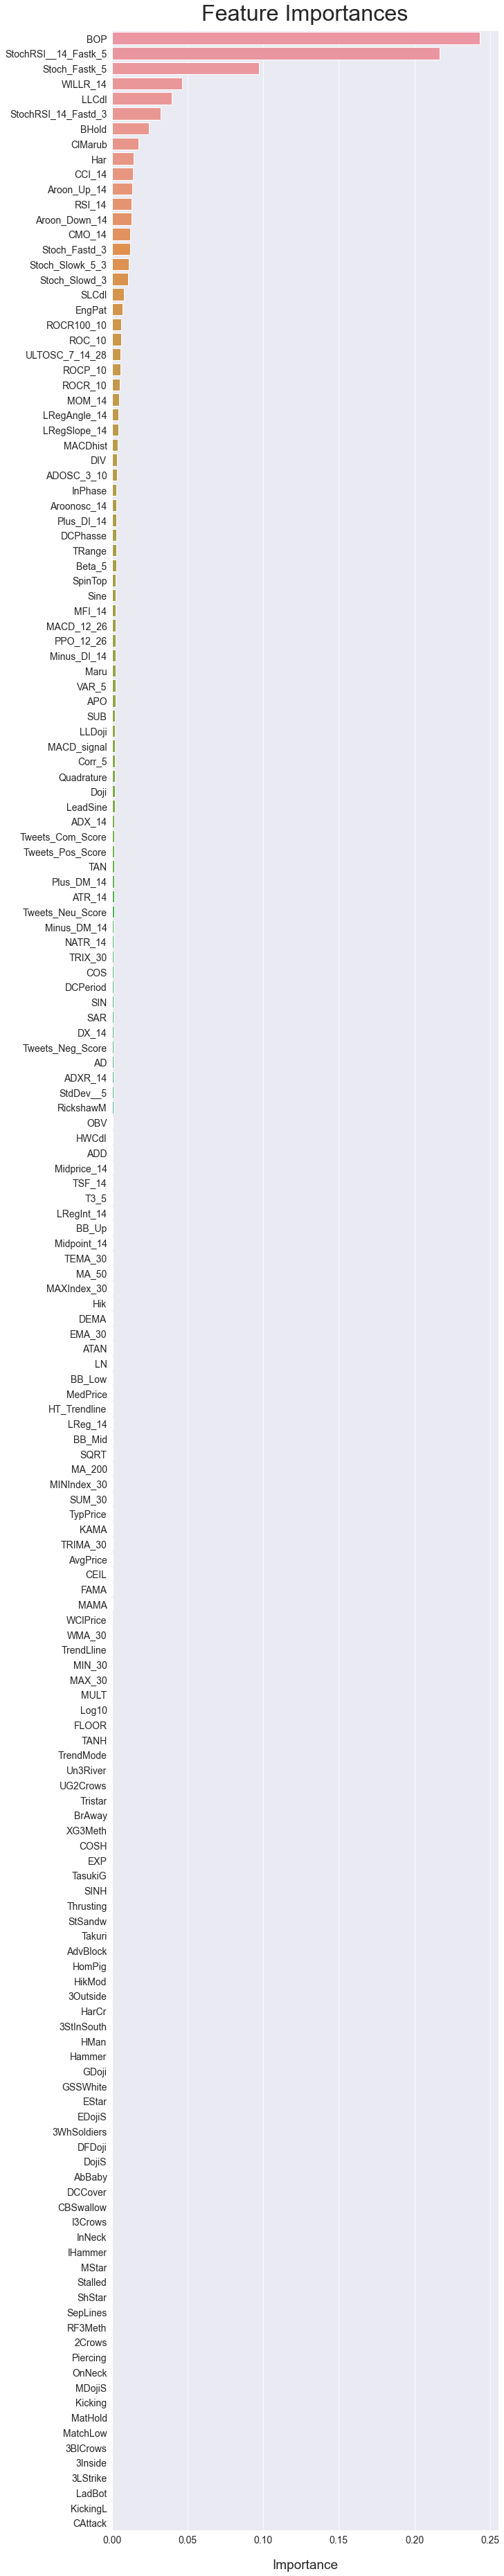


Do you wish to confirm the model and proceed to train the best model? [Y/n]: y

********************************************************************


-------------------------------------
| SAVE GRID SEARCH PARAMETERS FILES |
-------------------------------------

Do you want to save the file? [Y/n]: y

Existing files:


Grid Search Parameters 1:

- Filename: param_grid_2.json

{'bootstrap': [True],
 'criterion': ['gini'],
 'max_depth': [50, 100],
 'max_features': ['auto'],
 'min_samples_leaf': [2, 3],
 'min_samples_split': [2],
 'n_estimators': [100, 500, 800]}



Grid Search Parameters 2:

- Filename: default_param_grid.json

{'bootstrap': [True],
 'criterion': ['gini'],
 'max_depth': [None],
 'max_features': ['auto'],
 'min_samples_leaf': [1],
 'min_samples_split': [2],
 'n_estimators': [100]}



Grid Search Parameters 3:

- Filename: param_grid_1.json

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [20, 50, 100, 200, 300, 500],
 'max_features': ['au

In [171]:
# Train the machine learning model
TSLA_backtest_strategy.train_model()

If you run the "train_model" method with the parameters grid search to optimise the model training, one interesting thing you can observe is that the sentiment scores on the Twitter posts did not get a significant importance score compared to other features. However, it is worth to note also that no analysis has been carried out on the features' selection, therefore this may be a prompt for a further investigation on the model training to try to improve its predictive accuracy.



----------------------------------
| MODEL PARAMETERS FOLDERS CHECK |
----------------------------------

The "model_training_param" directory already exists. Checking for existing files...

- "default_best_param" file already existing.

- "default_param_grid" file already existing.

********************************************************************


------------------------------
| MODEL PARAMETERS SELECTION |
------------------------------

General instructions:
- To select a set of parameters, enter its number and press enter.

Existing files:


 Model Parameters: 1

- Filename: default_best_param.json

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}



 Model Parameters: 2

- Filename: best_param_2.json

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 800}



 Model P

Testing Score Summary                                         
                Accuracy (%) Precision (%) Recall (%) Specificity (%)
Scores              0.882583      0.902174   0.882979        0.882096

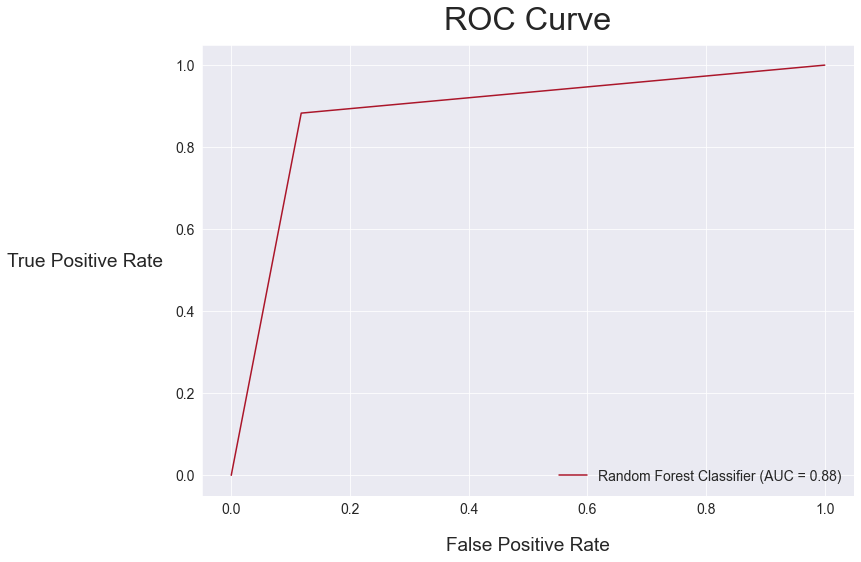


Do you want to repeat the model training? [Y/n]: n

Do you want to go ahead and print the strategy performance statistics? [Y/n]: y


--------------------------------------
| STRATEGY PERFORMANCE FOLDERS CHECK |
--------------------------------------

The "strategy_performance" folder already exists.

********************************************************************


--------------------------------
| TRADING STRATEGY PERFORMANCE |
--------------------------------




,Performance Indicators Summary
Return Buy and Hold (%),1618.59
Return Buy and Hold Ann. (%),305.94
Return Trading Strategy (%),1892.7
Return Trading Strategy Ann. (%),336.64
Sharpe Ratio Ann.,17.47
Total Number of Trades,244
Hit Ratio (%),90.98
Average Trades Profit (%),1.07
Average Trades Loss (%),-0.2
Max Drawdown (%),-1.24


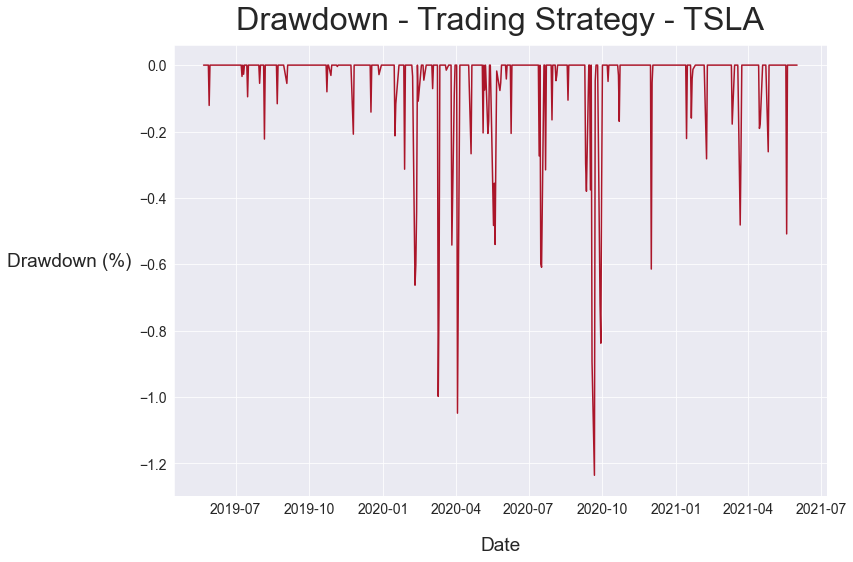

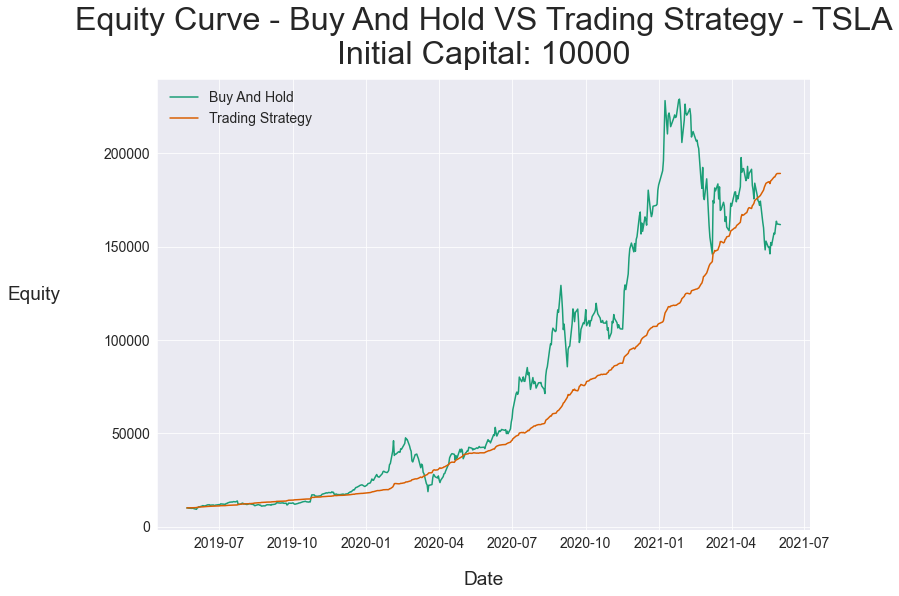

In [172]:
# Test the machine learning model
TSLA_backtest_strategy.test_model()


********************************************************************


--------------------------------
| TRADING STRATEGY PERFORMANCE |
--------------------------------




,Performance Indicators Summary
Return Buy and Hold (%),1618.59
Return Buy and Hold Ann. (%),305.94
Return Trading Strategy (%),1892.7
Return Trading Strategy Ann. (%),336.64
Sharpe Ratio Ann.,17.47
Total Number of Trades,244
Hit Ratio (%),90.98
Average Trades Profit (%),1.07
Average Trades Loss (%),-0.2
Max Drawdown (%),-1.24


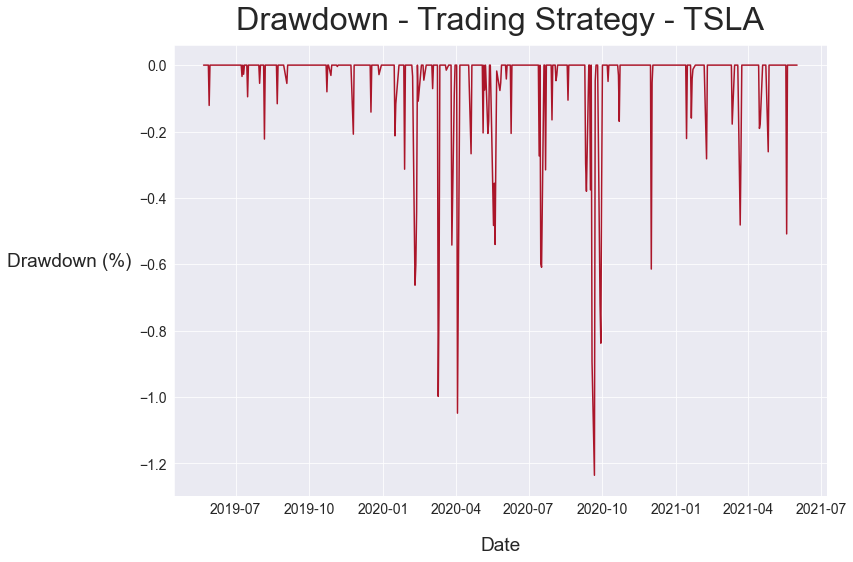

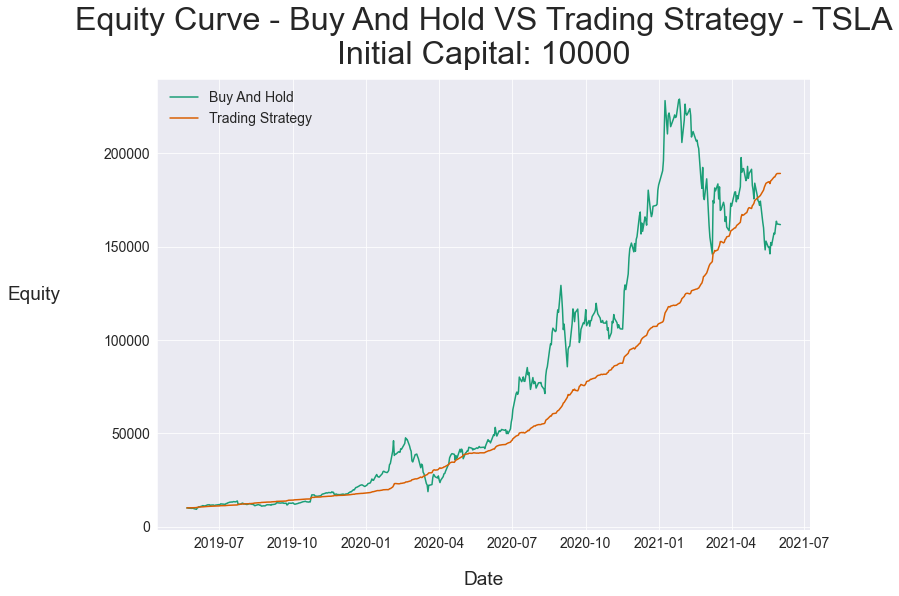

[CV 2/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=300;, score=0.895 total time=   1.9s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=30, min_samples_split=50, n_estimators=300;, score=0.877 total time=   1.8s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=50, n_estimators=100;, score=0.900 total time=   0.5s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=50, n_estimators=100;, score=0.882 total time=   0.5s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=50, n_estimators=300;, score=0.858 total time=   1.6s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=30, min_samples_split=50, n_estimators=100;, scor

[CV 3/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=100;, score=0.880 total time=   0.6s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=300;, score=0.877 total time=   1.8s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=10, n_estimators=100;, score=0.863 total time=   0.5s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=10, n_estimators=100;, score=0.865 total time=   0.5s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=10, n_estimators=300;, score=0.863 total time=   1.6s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=100;, scor

In [173]:
# Display the trading strategy performance
TSLA_backtest_strategy.strategy_performance(initial_capital=10000, traded_amount_pc=20, transaction_fee=0.05)

By trading the 20% of the capital at each trade and with a transaction fee of 0.05%, the trading strategy outperforms the return of the simple investment in the stock on the same period, with a return of 18 times the initial capital compared to the return of 1618% of the stock.

<a id='References'></a>
# References

1. [Minna Castoe, "Predicting Stock Market Price Direction with Uncertainty Using Quantile Regression Forest", Uppsala University (2020)](https://www.diva-portal.org/smash/get/diva2:1503760/FULLTEXT02)
2. [Venkata Sasank Pagolu, Kamal Nayan Reddy, Ganapati Panda, Babita Majhi. Sentiment analysis of Twitter data for predicting stock market movements, 2016 International Conference on Signal Processing, Communication, Power and Embedded System (SCOPES)](https://ieeexplore.ieee.org/abstract/document/7955659/metrics#metrics)
3. [Random Forest](https://en.wikipedia.org/wiki/Random_forest)
4. [Directed Acyclic Graph (DAG)](https://www.capgemini.com/gb-en/2020/10/introducing-directed-acyclic-graphs-and-their-use-cases/)
5. [Dataquest Data Engineer course](https://www.dataquest.io/path/data-engineer/)
6. [Idempotence](https://stackoverflow.com/questions/1077412/what-is-an-idempotent-operation)